# N:1 MENT — marginal projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.sim import copy_diagnostics
from ment.train.plot import Plotter
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

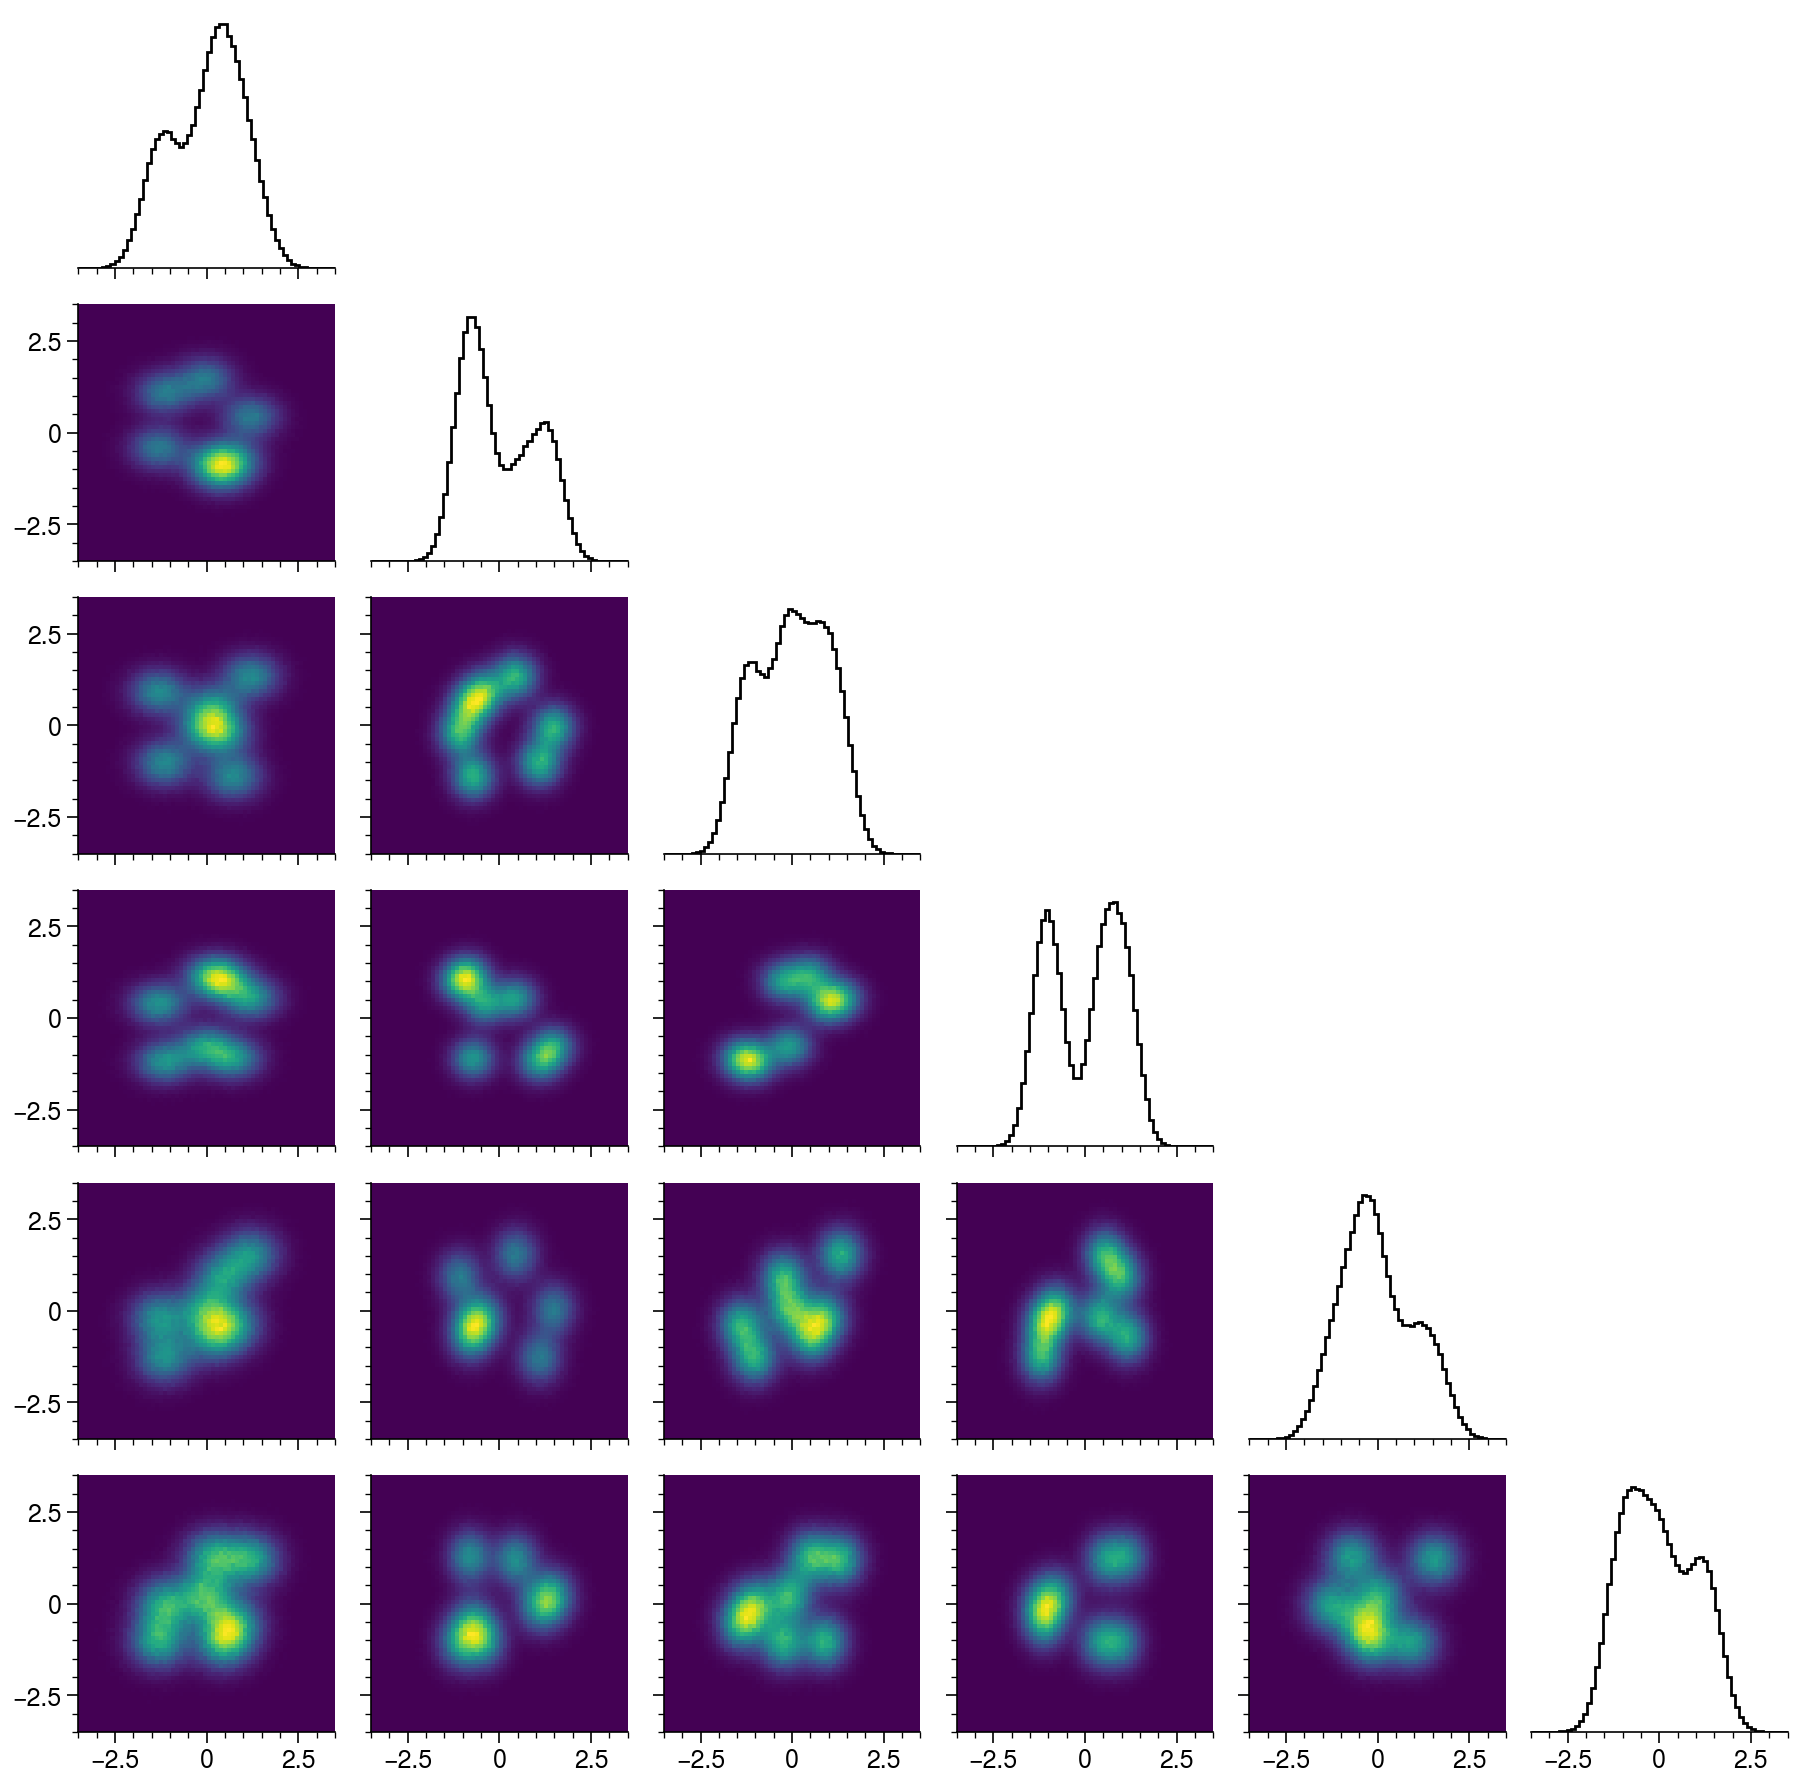

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
# Settings
nbins = 40
nmeas = ndim
kde = False
kde_bandwidth_frac = 1.0

## Measure 1D marginals
rng = np.random.default_rng(seed)
axis_meas = 0
n_meas = ndim

# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    j = axis_meas
    matrix = np.identity(ndim)
    matrix[i, i] = matrix[j, j] = 0.0
    matrix[i, j] = matrix[j, i] = 1.0
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

projections = []
for transform in transforms:
    projection = ment.diag.Histogram1D(
        axis=axis_meas, edges=bin_edges, kde=kde, kde_bandwidth_frac=kde_bandwidth_frac
    )
    projections.append([projection])

# Generate data.
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [7]:
sampler = "mcmc"
nsamp = 500_000
burnin = 10_000

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=248,
        proposal_cov=np.eye(ndim),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [8]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=True,
)

## Train

In [9]:
plot_nsamp = 1_000_000
plot_nbins = 64

In [10]:
plot_model = Plotter(
    n_samples=plot_nsamp,
    plot_proj=[
        PlotProj1D(log=False),
        PlotProj1D(log=True),
    ],
    plot_dist=[
        PlotDistCorner(
            fig_kws=dict(figwidth=(ndim * 1.25), diag_shrink=0.80),
            limits=(ndim * [(-xmax, xmax)]),
            bins=plot_nbins,
        ),
    ],
)

eval_model = ment.train.Evaluator(n_samples=plot_nsamp)

non numeric history values being saved


  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|███▉                                                                                                                                                           | 346/14031 [00:00<00:03, 3456.02it/s]

  5%|███████▉                                                                                                                                                       | 699/14031 [00:00<00:03, 3495.41it/s]

  8%|███████████▊                                                                                                                                                  | 1054/14031 [00:00<00:03, 3515.95it/s]

 10%|███████████████▊                                                                                                                                              | 1406/14031 [00:00<00:03, 3514.54it/s]

 13%|███████████████████▊                                                                                                                                          | 1758/14031 [00:00<00:03, 3394.89it/s]

 15%|███████████████████████▋                                                                                                                                      | 2099/14031 [00:00<00:03, 3336.07it/s]

 17%|███████████████████████████▍                                                                                                                                  | 2434/14031 [00:00<00:03, 3302.01it/s]

 20%|███████████████████████████████▏                                                                                                                              | 2765/14031 [00:00<00:03, 3297.20it/s]

 22%|██████████████████████████████████▊                                                                                                                           | 3096/14031 [00:00<00:03, 3298.57it/s]

 24%|██████████████████████████████████████▌                                                                                                                       | 3427/14031 [00:01<00:03, 3286.96it/s]

 27%|██████████████████████████████████████████▎                                                                                                                   | 3756/14031 [00:01<00:03, 3264.86it/s]

 29%|█████████████████████████████████████████████▉                                                                                                                | 4083/14031 [00:01<00:03, 3247.19it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                            | 4430/14031 [00:01<00:02, 3313.34it/s]

 34%|█████████████████████████████████████████████████████▋                                                                                                        | 4773/14031 [00:01<00:02, 3347.19it/s]

 36%|█████████████████████████████████████████████████████████▋                                                                                                    | 5120/14031 [00:01<00:02, 3382.33it/s]

 39%|█████████████████████████████████████████████████████████████▋                                                                                                | 5476/14031 [00:01<00:02, 3434.13it/s]

 41%|█████████████████████████████████████████████████████████████████▌                                                                                            | 5820/14031 [00:01<00:02, 3368.19it/s]

 44%|█████████████████████████████████████████████████████████████████████▎                                                                                        | 6158/14031 [00:01<00:02, 3346.59it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                     | 6493/14031 [00:01<00:02, 3295.40it/s]

 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                 | 6823/14031 [00:02<00:02, 3228.01it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                             | 7147/14031 [00:02<00:02, 3166.52it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                          | 7466/14031 [00:02<00:02, 3170.87it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 7797/14031 [00:02<00:01, 3209.10it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 8128/14031 [00:02<00:01, 3238.39it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 8458/14031 [00:02<00:01, 3256.34it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 8784/14031 [00:02<00:01, 3239.05it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 9120/14031 [00:02<00:01, 3274.00it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 9469/14031 [00:02<00:01, 3337.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 9820/14031 [00:02<00:01, 3388.37it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 10169/14031 [00:03<00:01, 3417.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 10520/14031 [00:03<00:01, 3444.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 10871/14031 [00:03<00:00, 3463.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 11218/14031 [00:03<00:00, 3463.09it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 11568/14031 [00:03<00:00, 3471.48it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 11925/14031 [00:03<00:00, 3499.68it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 12279/14031 [00:03<00:00, 3511.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 12635/14031 [00:03<00:00, 3525.49it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 12988/14031 [00:03<00:00, 3509.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 13339/14031 [00:03<00:00, 3500.62it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 13690/14031 [00:04<00:00, 3483.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:04<00:00, 3370.14it/s]

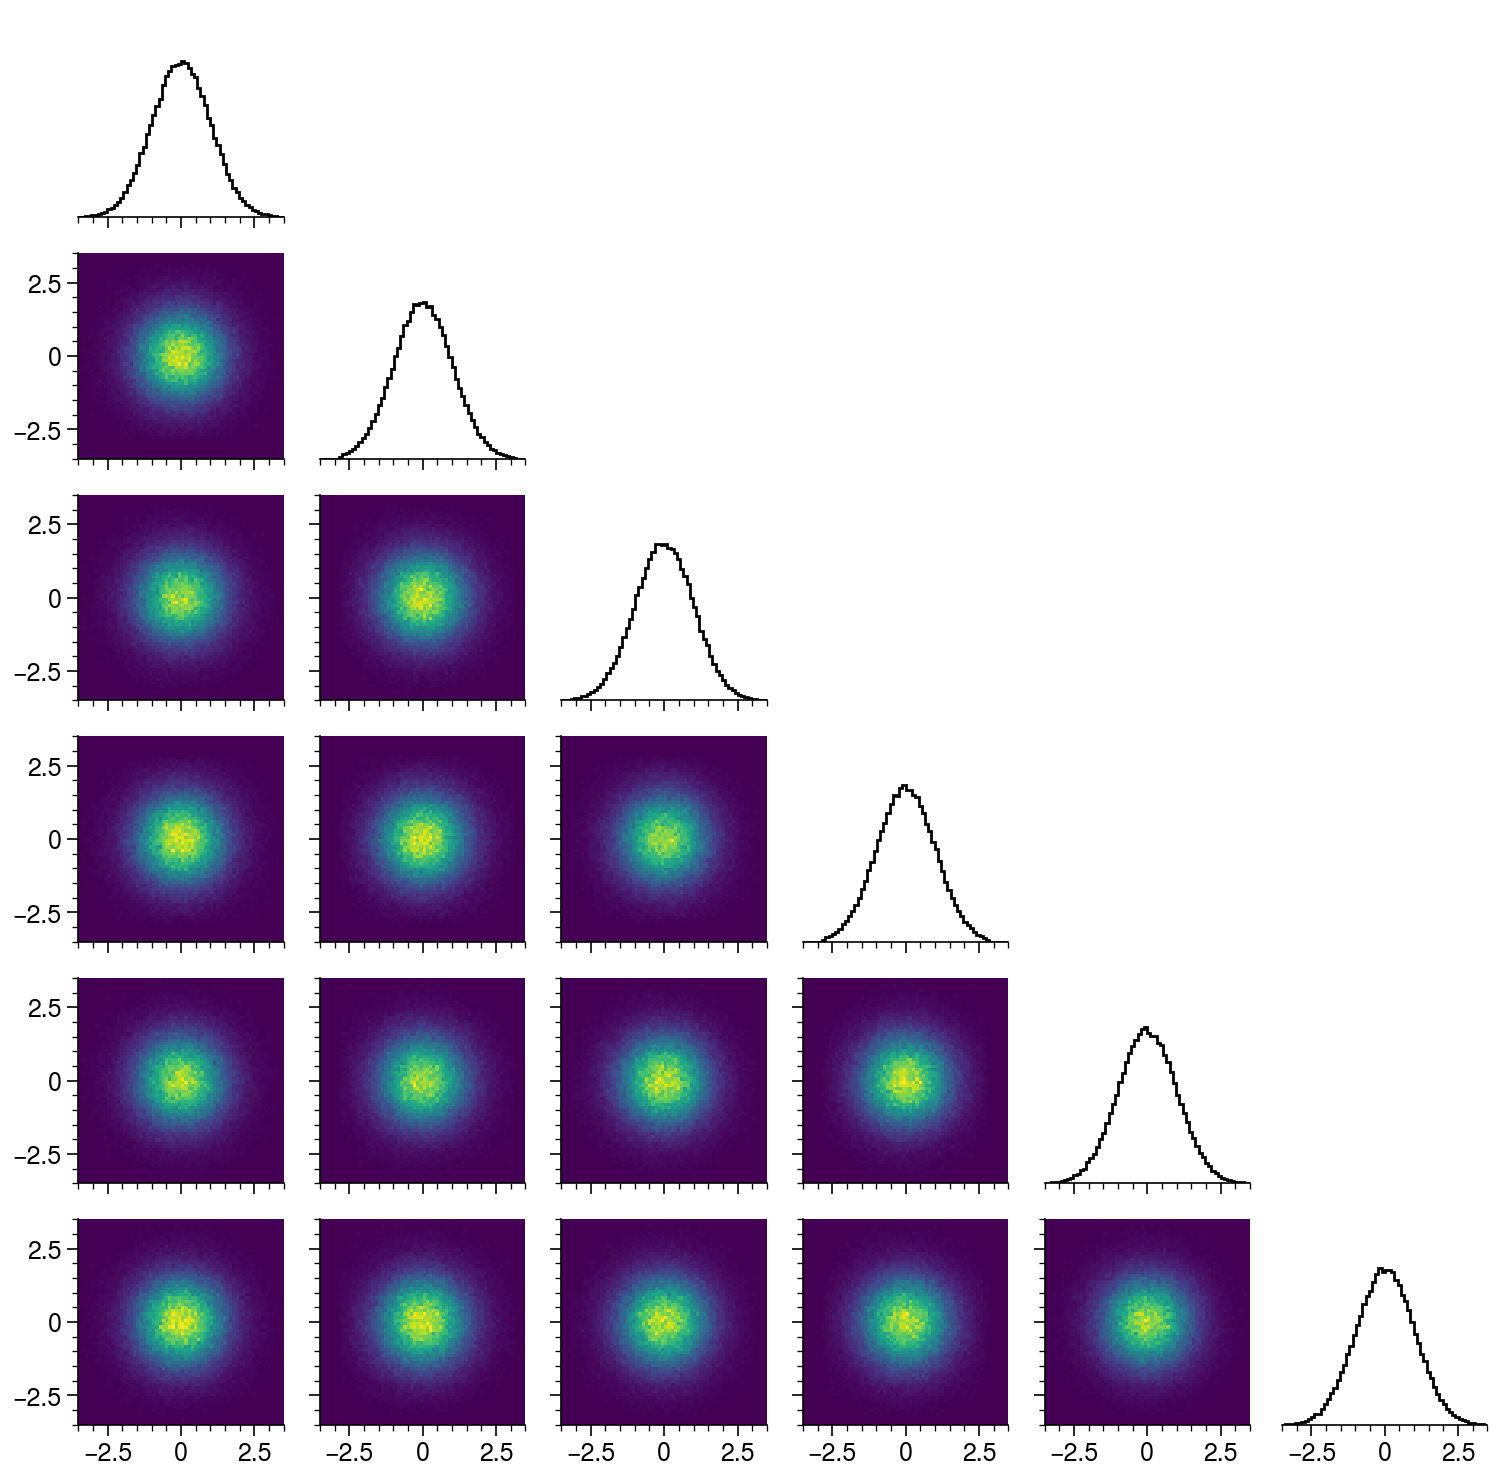

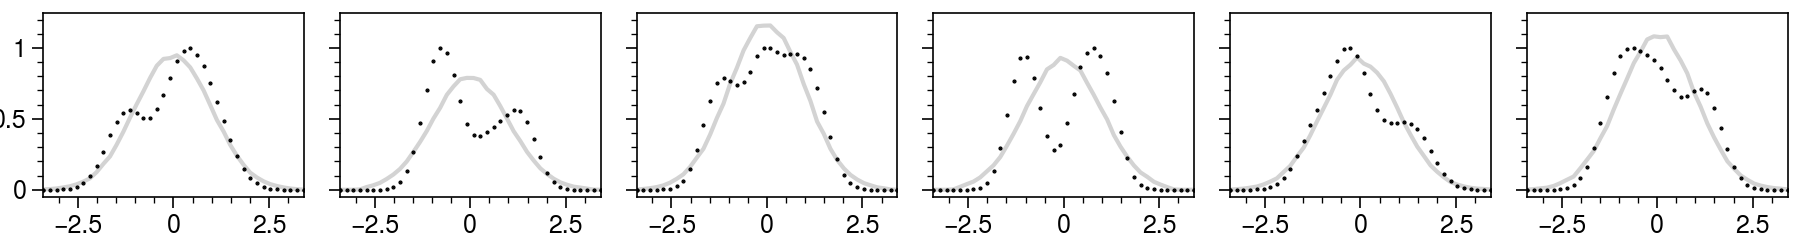

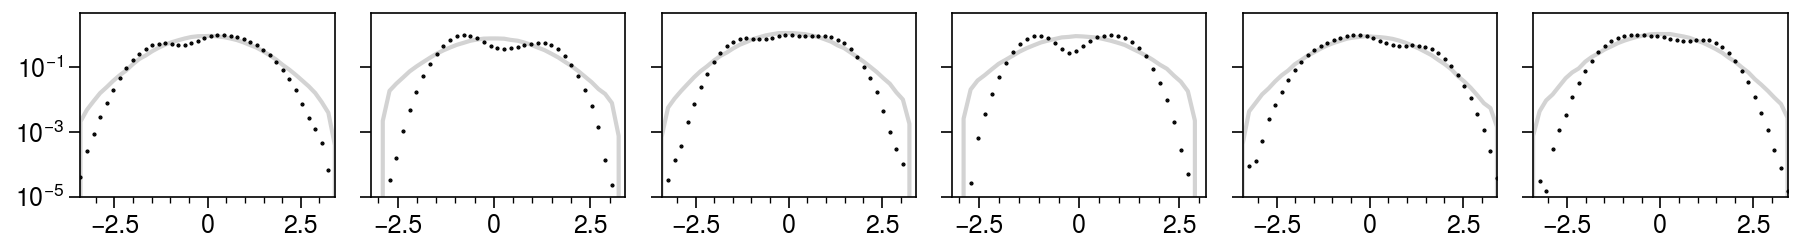

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  3%|████▏                                                                                                                                                          | 365/14031 [00:00<00:03, 3646.58it/s]

  5%|████████▎                                                                                                                                                      | 734/14031 [00:00<00:03, 3667.82it/s]

  8%|████████████▍                                                                                                                                                 | 1104/14031 [00:00<00:03, 3679.39it/s]

 11%|████████████████▌                                                                                                                                             | 1475/14031 [00:00<00:03, 3688.68it/s]

 13%|████████████████████▊                                                                                                                                         | 1845/14031 [00:00<00:03, 3690.34it/s]

 16%|████████████████████████▉                                                                                                                                     | 2215/14031 [00:00<00:03, 3692.22it/s]

 18%|█████████████████████████████                                                                                                                                 | 2586/14031 [00:00<00:03, 3695.23it/s]

 21%|█████████████████████████████████▎                                                                                                                            | 2957/14031 [00:00<00:02, 3696.76it/s]

 24%|█████████████████████████████████████▍                                                                                                                        | 3327/14031 [00:00<00:02, 3686.95it/s]

 26%|█████████████████████████████████████████▋                                                                                                                    | 3698/14031 [00:01<00:02, 3691.48it/s]

 29%|█████████████████████████████████████████████▊                                                                                                                | 4068/14031 [00:01<00:02, 3684.45it/s]

 32%|█████████████████████████████████████████████████▉                                                                                                            | 4437/14031 [00:01<00:02, 3685.63it/s]

 34%|██████████████████████████████████████████████████████                                                                                                        | 4806/14031 [00:01<00:02, 3681.82it/s]

 37%|██████████████████████████████████████████████████████████▎                                                                                                   | 5176/14031 [00:01<00:02, 3684.30it/s]

 40%|██████████████████████████████████████████████████████████████▍                                                                                               | 5547/14031 [00:01<00:02, 3690.94it/s]

 42%|██████████████████████████████████████████████████████████████████▋                                                                                           | 5917/14031 [00:01<00:02, 3690.77it/s]

 45%|██████████████████████████████████████████████████████████████████████▊                                                                                       | 6289/14031 [00:01<00:02, 3696.73it/s]

 47%|███████████████████████████████████████████████████████████████████████████                                                                                   | 6661/14031 [00:01<00:01, 3701.60it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                              | 7032/14031 [00:01<00:01, 3703.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                          | 7403/14031 [00:02<00:01, 3704.08it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 7774/14031 [00:02<00:01, 3702.29it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 8146/14031 [00:02<00:01, 3704.71it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 8519/14031 [00:02<00:01, 3710.23it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 8892/14031 [00:02<00:01, 3713.33it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 9265/14031 [00:02<00:01, 3716.39it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 9637/14031 [00:02<00:01, 3715.43it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 10009/14031 [00:02<00:01, 3714.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 10381/14031 [00:02<00:00, 3704.44it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 10753/14031 [00:02<00:00, 3707.27it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 11124/14031 [00:03<00:00, 3698.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 11494/14031 [00:03<00:00, 3694.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 11864/14031 [00:03<00:00, 3694.98it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 12234/14031 [00:03<00:00, 3695.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 12604/14031 [00:03<00:00, 3690.44it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 12974/14031 [00:03<00:00, 3688.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 13343/14031 [00:03<00:00, 3687.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 13715/14031 [00:03<00:00, 3694.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3695.47it/s]

{'mean_abs_error': np.float64(0.04358625790038392)}
epoch = 1
transform=0
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▊                                                                                                                                                          | 367/12015 [00:00<00:03, 3662.01it/s]

  6%|█████████▋                                                                                                                                                     | 736/12015 [00:00<00:03, 3676.99it/s]

  9%|██████████████▌                                                                                                                                               | 1107/12015 [00:00<00:02, 3690.33it/s]

 12%|███████████████████▍                                                                                                                                          | 1479/12015 [00:00<00:02, 3698.77it/s]

 15%|████████████████████████▎                                                                                                                                     | 1849/12015 [00:00<00:02, 3695.98it/s]

 18%|█████████████████████████████▏                                                                                                                                | 2219/12015 [00:00<00:02, 3694.58it/s]

 22%|██████████████████████████████████                                                                                                                            | 2589/12015 [00:00<00:02, 3691.16it/s]

 25%|██████████████████████████████████████▉                                                                                                                       | 2959/12015 [00:00<00:02, 3692.98it/s]

 28%|███████████████████████████████████████████▊                                                                                                                  | 3329/12015 [00:00<00:02, 3689.37it/s]

 31%|████████████████████████████████████████████████▋                                                                                                             | 3698/12015 [00:01<00:02, 3686.86it/s]

 34%|█████████████████████████████████████████████████████▍                                                                                                        | 4067/12015 [00:01<00:02, 3680.23it/s]

 37%|██████████████████████████████████████████████████████████▎                                                                                                   | 4436/12015 [00:01<00:02, 3679.67it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 4808/12015 [00:01<00:01, 3690.10it/s]

 43%|████████████████████████████████████████████████████████████████████                                                                                          | 5178/12015 [00:01<00:01, 3692.67it/s]

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                     | 5548/12015 [00:01<00:01, 3694.19it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                | 5920/12015 [00:01<00:01, 3699.99it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                           | 6291/12015 [00:01<00:01, 3702.08it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 6664/12015 [00:01<00:01, 3708.46it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7037/12015 [00:01<00:01, 3713.52it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 7410/12015 [00:02<00:01, 3716.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 7782/12015 [00:02<00:01, 3713.50it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 8154/12015 [00:02<00:01, 3713.75it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 8527/12015 [00:02<00:00, 3717.38it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 8899/12015 [00:02<00:00, 3716.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 9271/12015 [00:02<00:00, 3715.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 9644/12015 [00:02<00:00, 3717.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 10017/12015 [00:02<00:00, 3719.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 10390/12015 [00:02<00:00, 3722.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10763/12015 [00:02<00:00, 3721.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 11136/12015 [00:03<00:00, 3720.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 11509/12015 [00:03<00:00, 3720.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 11882/12015 [00:03<00:00, 3722.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3705.12it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▊                                                                                                                                                          | 367/12015 [00:00<00:03, 3666.71it/s]

  6%|█████████▊                                                                                                                                                     | 738/12015 [00:00<00:03, 3688.06it/s]

  9%|██████████████▌                                                                                                                                               | 1109/12015 [00:00<00:02, 3697.12it/s]

 12%|███████████████████▍                                                                                                                                          | 1482/12015 [00:00<00:02, 3706.88it/s]

 15%|████████████████████████▍                                                                                                                                     | 1854/12015 [00:00<00:02, 3710.87it/s]

 19%|█████████████████████████████▎                                                                                                                                | 2226/12015 [00:00<00:02, 3712.65it/s]

 22%|██████████████████████████████████▏                                                                                                                           | 2598/12015 [00:00<00:02, 3702.75it/s]

 25%|███████████████████████████████████████                                                                                                                       | 2969/12015 [00:00<00:02, 3691.28it/s]

 28%|███████████████████████████████████████████▉                                                                                                                  | 3339/12015 [00:00<00:02, 3692.62it/s]

 31%|████████████████████████████████████████████████▊                                                                                                             | 3709/12015 [00:01<00:02, 3687.22it/s]

 34%|█████████████████████████████████████████████████████▋                                                                                                        | 4078/12015 [00:01<00:02, 3687.52it/s]

 37%|██████████████████████████████████████████████████████████▍                                                                                                   | 4447/12015 [00:01<00:02, 3684.15it/s]

 40%|███████████████████████████████████████████████████████████████▎                                                                                              | 4816/12015 [00:01<00:01, 3669.61it/s]

 43%|████████████████████████████████████████████████████████████████████▏                                                                                         | 5186/12015 [00:01<00:01, 3676.54it/s]

 46%|█████████████████████████████████████████████████████████████████████████                                                                                     | 5558/12015 [00:01<00:01, 3688.13it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▉                                                                                | 5928/12015 [00:01<00:01, 3689.02it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                           | 6297/12015 [00:01<00:01, 3638.46it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6661/12015 [00:01<00:01, 3605.20it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 7022/12015 [00:01<00:01, 3580.01it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 7381/12015 [00:02<00:01, 3556.24it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 7737/12015 [00:02<00:01, 3547.34it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 8093/12015 [00:02<00:01, 3547.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 8452/12015 [00:02<00:01, 3559.24it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8810/12015 [00:02<00:00, 3564.94it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 9168/12015 [00:02<00:00, 3567.31it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 9527/12015 [00:02<00:00, 3571.69it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 9885/12015 [00:02<00:00, 3572.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 10243/12015 [00:02<00:00, 3570.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10602/12015 [00:02<00:00, 3574.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 10961/12015 [00:03<00:00, 3576.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11320/12015 [00:03<00:00, 3579.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 11680/12015 [00:03<00:00, 3583.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3623.87it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 358/12015 [00:00<00:03, 3573.18it/s]

  6%|█████████▍                                                                                                                                                     | 716/12015 [00:00<00:03, 3577.00it/s]

  9%|██████████████▏                                                                                                                                               | 1078/12015 [00:00<00:03, 3592.81it/s]

 12%|██████████████████▉                                                                                                                                           | 1439/12015 [00:00<00:02, 3597.88it/s]

 15%|███████████████████████▋                                                                                                                                      | 1799/12015 [00:00<00:02, 3591.04it/s]

 18%|████████████████████████████▍                                                                                                                                 | 2159/12015 [00:00<00:02, 3591.78it/s]

 21%|█████████████████████████████████▏                                                                                                                            | 2521/12015 [00:00<00:02, 3597.71it/s]

 24%|█████████████████████████████████████▉                                                                                                                        | 2881/12015 [00:00<00:02, 3597.07it/s]

 27%|██████████████████████████████████████████▌                                                                                                                   | 3241/12015 [00:00<00:02, 3587.55it/s]

 30%|███████████████████████████████████████████████▎                                                                                                              | 3600/12015 [00:01<00:02, 3579.48it/s]

 33%|████████████████████████████████████████████████████                                                                                                          | 3959/12015 [00:01<00:02, 3579.70it/s]

 36%|████████████████████████████████████████████████████████▊                                                                                                     | 4317/12015 [00:01<00:02, 3570.88it/s]

 39%|█████████████████████████████████████████████████████████████▍                                                                                                | 4675/12015 [00:01<00:02, 3542.61it/s]

 42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 5037/12015 [00:01<00:01, 3564.57it/s]

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                       | 5394/12015 [00:01<00:01, 3531.21it/s]

 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                  | 5752/12015 [00:01<00:01, 3545.32it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                             | 6107/12015 [00:01<00:01, 3542.90it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 6462/12015 [00:01<00:01, 3532.53it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 6816/12015 [00:01<00:01, 3521.34it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 7171/12015 [00:02<00:01, 3529.59it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 7524/12015 [00:02<00:01, 3528.60it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7877/12015 [00:02<00:01, 3519.09it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 8229/12015 [00:02<00:01, 3512.49it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8582/12015 [00:02<00:00, 3515.51it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 8938/12015 [00:02<00:00, 3528.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 9293/12015 [00:02<00:00, 3534.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 9648/12015 [00:02<00:00, 3536.73it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 10002/12015 [00:02<00:00, 3526.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 10355/12015 [00:02<00:00, 3514.69it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10707/12015 [00:03<00:00, 3515.42it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 11059/12015 [00:03<00:00, 3511.93it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 11412/12015 [00:03<00:00, 3516.16it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 11767/12015 [00:03<00:00, 3524.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3544.16it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 356/12015 [00:00<00:03, 3557.97it/s]

  6%|█████████▍                                                                                                                                                     | 715/12015 [00:00<00:03, 3572.06it/s]

  9%|██████████████                                                                                                                                                | 1074/12015 [00:00<00:03, 3576.48it/s]

 12%|██████████████████▊                                                                                                                                           | 1432/12015 [00:00<00:02, 3573.67it/s]

 15%|███████████████████████▌                                                                                                                                      | 1790/12015 [00:00<00:02, 3575.02it/s]

 18%|████████████████████████████▎                                                                                                                                 | 2149/12015 [00:00<00:02, 3579.53it/s]

 21%|████████████████████████████████▉                                                                                                                             | 2508/12015 [00:00<00:02, 3582.56it/s]

 24%|█████████████████████████████████████▋                                                                                                                        | 2867/12015 [00:00<00:02, 3579.10it/s]

 27%|██████████████████████████████████████████▍                                                                                                                   | 3225/12015 [00:00<00:02, 3547.62it/s]

 30%|███████████████████████████████████████████████                                                                                                               | 3583/12015 [00:01<00:02, 3555.31it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                          | 3942/12015 [00:01<00:02, 3565.32it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                     | 4301/12015 [00:01<00:02, 3571.96it/s]

 39%|█████████████████████████████████████████████████████████████▎                                                                                                | 4660/12015 [00:01<00:02, 3575.80it/s]

 42%|██████████████████████████████████████████████████████████████████                                                                                            | 5019/12015 [00:01<00:01, 3579.85it/s]

 45%|██████████████████████████████████████████████████████████████████████▋                                                                                       | 5379/12015 [00:01<00:01, 3583.32it/s]

 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                  | 5740/12015 [00:01<00:01, 3590.18it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                             | 6102/12015 [00:01<00:01, 3596.35it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 6463/12015 [00:01<00:01, 3599.20it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 6823/12015 [00:01<00:01, 3594.17it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 7183/12015 [00:02<00:01, 3592.01it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7544/12015 [00:02<00:01, 3595.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7905/12015 [00:02<00:01, 3598.93it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 8265/12015 [00:02<00:01, 3599.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 8625/12015 [00:02<00:00, 3594.05it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 8985/12015 [00:02<00:00, 3592.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9345/12015 [00:02<00:00, 3558.25it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 9704/12015 [00:02<00:00, 3566.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 10061/12015 [00:02<00:00, 3549.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 10421/12015 [00:02<00:00, 3563.36it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 10778/12015 [00:03<00:00, 3549.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 11134/12015 [00:03<00:00, 3546.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 11495/12015 [00:03<00:00, 3563.36it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 11852/12015 [00:03<00:00, 3551.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3572.33it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 353/12015 [00:00<00:03, 3523.51it/s]

  6%|█████████▎                                                                                                                                                     | 706/12015 [00:00<00:03, 3517.26it/s]

  9%|██████████████                                                                                                                                                | 1065/12015 [00:00<00:03, 3548.26it/s]

 12%|██████████████████▊                                                                                                                                           | 1427/12015 [00:00<00:02, 3574.70it/s]

 15%|███████████████████████▍                                                                                                                                      | 1785/12015 [00:00<00:02, 3529.32it/s]

 18%|████████████████████████████▏                                                                                                                                 | 2139/12015 [00:00<00:02, 3503.47it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2496/12015 [00:00<00:02, 3524.23it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 2856/12015 [00:00<00:02, 3547.04it/s]

 27%|██████████████████████████████████████████▏                                                                                                                   | 3211/12015 [00:00<00:02, 3541.51it/s]

 30%|██████████████████████████████████████████████▉                                                                                                               | 3566/12015 [00:01<00:02, 3534.95it/s]

 33%|███████████████████████████████████████████████████▌                                                                                                          | 3924/12015 [00:01<00:02, 3545.89it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4279/12015 [00:01<00:02, 3524.24it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                                 | 4634/12015 [00:01<00:02, 3529.48it/s]

 42%|█████████████████████████████████████████████████████████████████▌                                                                                            | 4989/12015 [00:01<00:01, 3534.79it/s]

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                       | 5343/12015 [00:01<00:01, 3530.17it/s]

 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                   | 5697/12015 [00:01<00:01, 3522.79it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                              | 6052/12015 [00:01<00:01, 3528.64it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 6412/12015 [00:01<00:01, 3547.61it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6767/12015 [00:01<00:01, 3539.12it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 7121/12015 [00:02<00:01, 3528.34it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 7476/12015 [00:02<00:01, 3532.73it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7830/12015 [00:02<00:01, 3525.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 8184/12015 [00:02<00:01, 3527.41it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 8541/12015 [00:02<00:00, 3539.01it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 8895/12015 [00:02<00:00, 3537.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 9252/12015 [00:02<00:00, 3544.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 9607/12015 [00:02<00:00, 3533.35it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 9964/12015 [00:02<00:00, 3543.31it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 10324/12015 [00:02<00:00, 3557.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 10683/12015 [00:03<00:00, 3567.27it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 11043/12015 [00:03<00:00, 3574.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11402/12015 [00:03<00:00, 3579.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 11760/12015 [00:03<00:00, 3558.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3542.05it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                                          | 333/12015 [00:00<00:03, 3323.48it/s]

  6%|████████▉                                                                                                                                                      | 677/12015 [00:00<00:03, 3390.35it/s]

  9%|█████████████▌                                                                                                                                                | 1029/12015 [00:00<00:03, 3446.62it/s]

 12%|██████████████████▏                                                                                                                                           | 1387/12015 [00:00<00:03, 3498.40it/s]

 14%|██████████████████████▉                                                                                                                                       | 1742/12015 [00:00<00:02, 3515.40it/s]

 17%|███████████████████████████▋                                                                                                                                  | 2102/12015 [00:00<00:02, 3541.01it/s]

 20%|████████████████████████████████▎                                                                                                                             | 2457/12015 [00:00<00:02, 3531.02it/s]

 23%|████████████████████████████████████▉                                                                                                                         | 2812/12015 [00:00<00:02, 3536.24it/s]

 26%|█████████████████████████████████████████▋                                                                                                                    | 3170/12015 [00:00<00:02, 3547.16it/s]

 29%|██████████████████████████████████████████████▍                                                                                                               | 3527/12015 [00:01<00:02, 3553.73it/s]

 32%|███████████████████████████████████████████████████                                                                                                           | 3884/12015 [00:01<00:02, 3558.60it/s]

 35%|███████████████████████████████████████████████████████▊                                                                                                      | 4242/12015 [00:01<00:02, 3564.27it/s]

 38%|████████████████████████████████████████████████████████████▌                                                                                                 | 4601/12015 [00:01<00:02, 3569.86it/s]

 41%|█████████████████████████████████████████████████████████████████▏                                                                                            | 4959/12015 [00:01<00:01, 3570.70it/s]

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                        | 5317/12015 [00:01<00:01, 3569.78it/s]

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                   | 5675/12015 [00:01<00:01, 3571.14it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                              | 6034/12015 [00:01<00:01, 3575.13it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                          | 6392/12015 [00:01<00:01, 3574.59it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 6750/12015 [00:01<00:01, 3570.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7109/12015 [00:02<00:01, 3574.04it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 7468/12015 [00:02<00:01, 3577.11it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7827/12015 [00:02<00:01, 3579.08it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 8186/12015 [00:02<00:01, 3582.24it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8549/12015 [00:02<00:00, 3594.59it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8910/12015 [00:02<00:00, 3597.51it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 9272/12015 [00:02<00:00, 3602.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 9634/12015 [00:02<00:00, 3607.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 9997/12015 [00:02<00:00, 3613.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 10360/12015 [00:02<00:00, 3617.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10724/12015 [00:03<00:00, 3623.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 11087/12015 [00:03<00:00, 3617.99it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11450/12015 [00:03<00:00, 3618.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 11813/12015 [00:03<00:00, 3620.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3572.78it/s]

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  3%|███▉                                                                                                                                                           | 352/14031 [00:00<00:03, 3514.10it/s]

  5%|████████                                                                                                                                                       | 709/14031 [00:00<00:03, 3545.54it/s]

  8%|████████████                                                                                                                                                  | 1066/14031 [00:00<00:03, 3555.96it/s]

 10%|████████████████                                                                                                                                              | 1423/14031 [00:00<00:03, 3560.98it/s]

 13%|████████████████████                                                                                                                                          | 1783/14031 [00:00<00:03, 3571.44it/s]

 15%|████████████████████████▏                                                                                                                                     | 2148/14031 [00:00<00:03, 3595.08it/s]

 18%|████████████████████████████▎                                                                                                                                 | 2514/14031 [00:00<00:03, 3615.61it/s]

 21%|████████████████████████████████▍                                                                                                                             | 2878/14031 [00:00<00:03, 3620.32it/s]

 23%|████████████████████████████████████▍                                                                                                                         | 3241/14031 [00:00<00:02, 3613.75it/s]

 26%|████████████████████████████████████████▌                                                                                                                     | 3603/14031 [00:01<00:02, 3602.33it/s]

 28%|████████████████████████████████████████████▋                                                                                                                 | 3964/14031 [00:01<00:02, 3594.17it/s]

 31%|████████████████████████████████████████████████▋                                                                                                             | 4324/14031 [00:01<00:02, 3564.98it/s]

 33%|████████████████████████████████████████████████████▋                                                                                                         | 4681/14031 [00:01<00:02, 3542.03it/s]

 36%|████████████████████████████████████████████████████████▋                                                                                                     | 5036/14031 [00:01<00:02, 3543.25it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                 | 5392/14031 [00:01<00:02, 3547.52it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                             | 5748/14031 [00:01<00:02, 3551.23it/s]

 44%|████████████████████████████████████████████████████████████████████▋                                                                                         | 6104/14031 [00:01<00:02, 3540.11it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                     | 6459/14031 [00:01<00:02, 3523.27it/s]

 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                 | 6812/14031 [00:01<00:02, 3524.11it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                             | 7165/14031 [00:02<00:01, 3509.53it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 7516/14031 [00:02<00:01, 3501.18it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 7867/14031 [00:02<00:01, 3495.55it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 8220/14031 [00:02<00:01, 3504.14it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 8571/14031 [00:02<00:01, 3502.58it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 8923/14031 [00:02<00:01, 3507.26it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 9278/14031 [00:02<00:01, 3519.50it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 9633/14031 [00:02<00:01, 3527.23it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 9989/14031 [00:02<00:01, 3535.20it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 10346/14031 [00:02<00:01, 3543.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 10701/14031 [00:03<00:00, 3529.77it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 11056/14031 [00:03<00:00, 3534.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 11413/14031 [00:03<00:00, 3542.49it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 11771/14031 [00:03<00:00, 3551.16it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 12127/14031 [00:03<00:00, 3543.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 12483/14031 [00:03<00:00, 3546.51it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 12838/14031 [00:03<00:00, 3528.10it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 13191/14031 [00:03<00:00, 3526.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 13544/14031 [00:03<00:00, 3518.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 13901/14031 [00:03<00:00, 3532.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3542.87it/s]

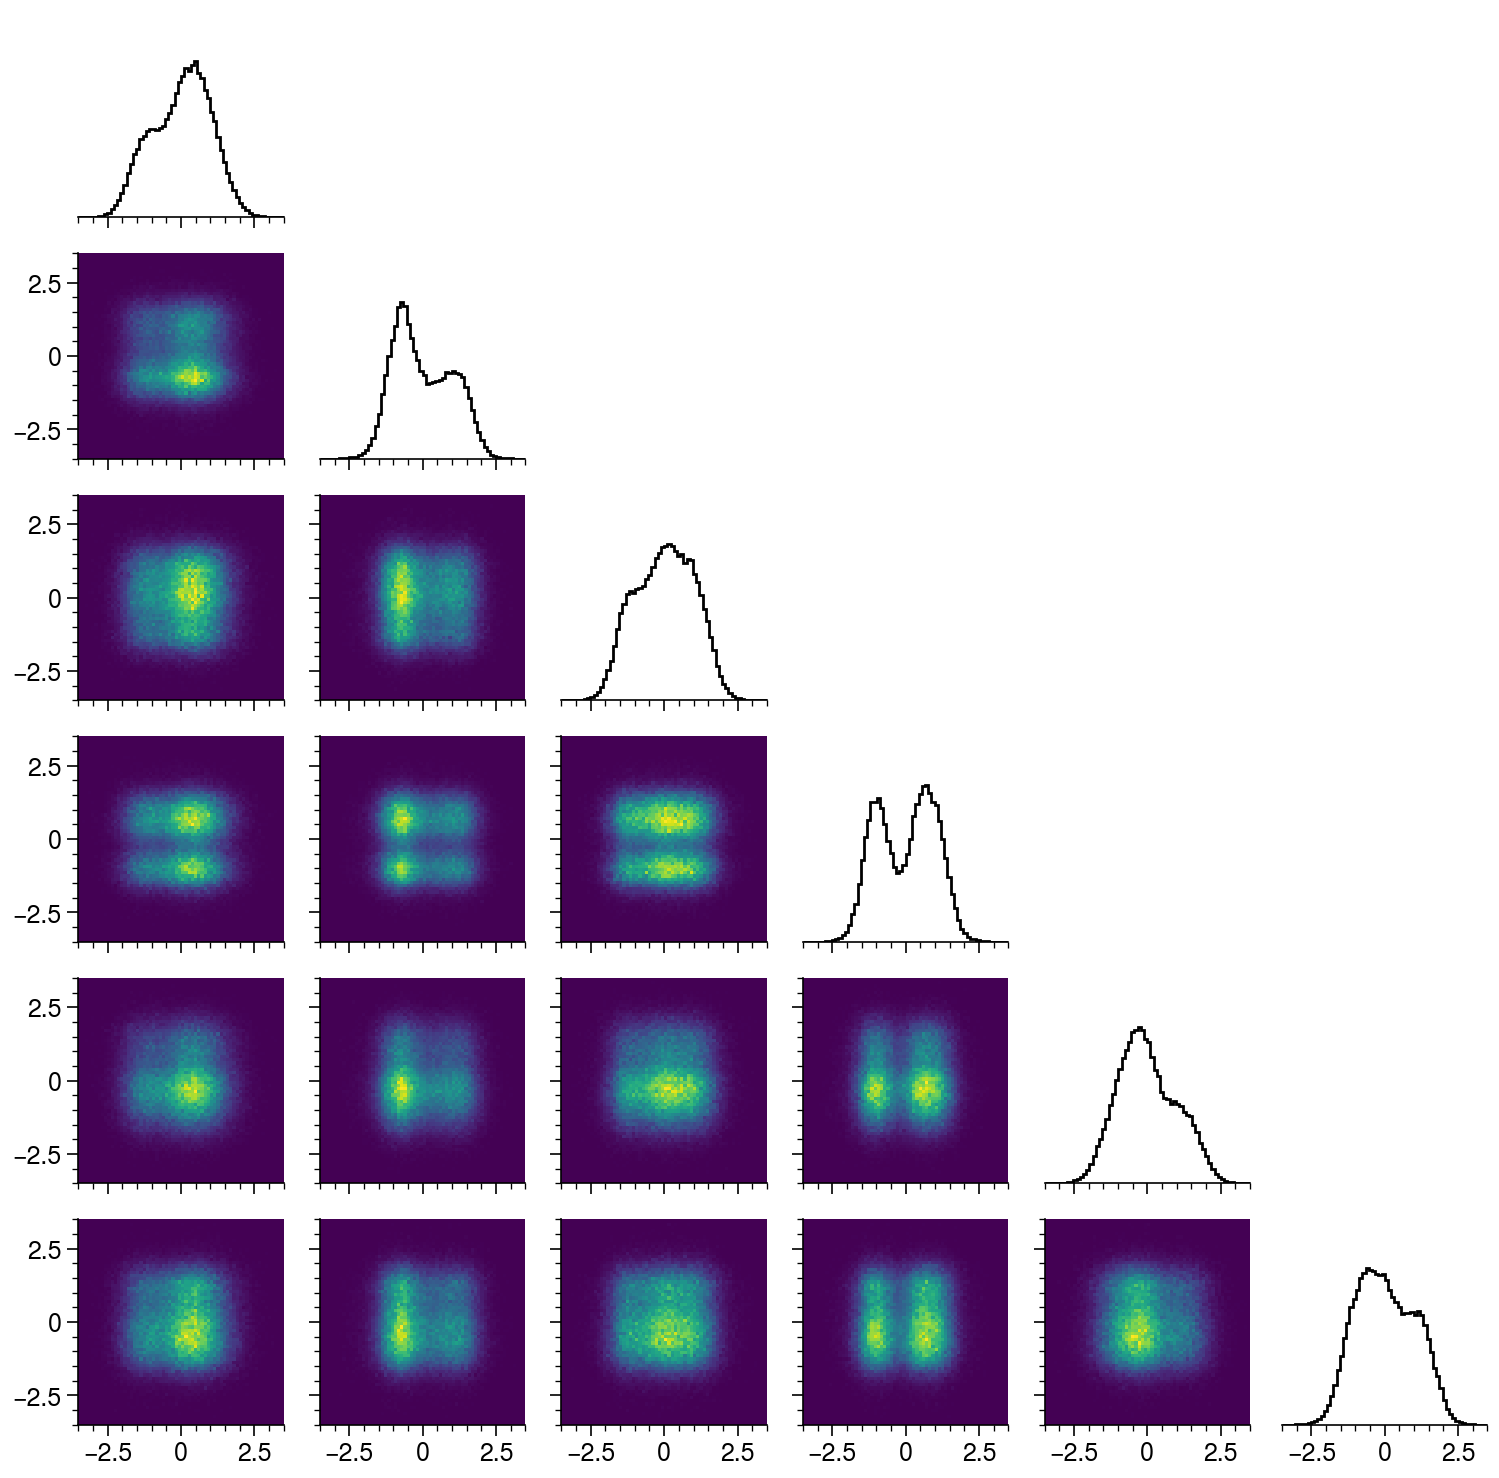

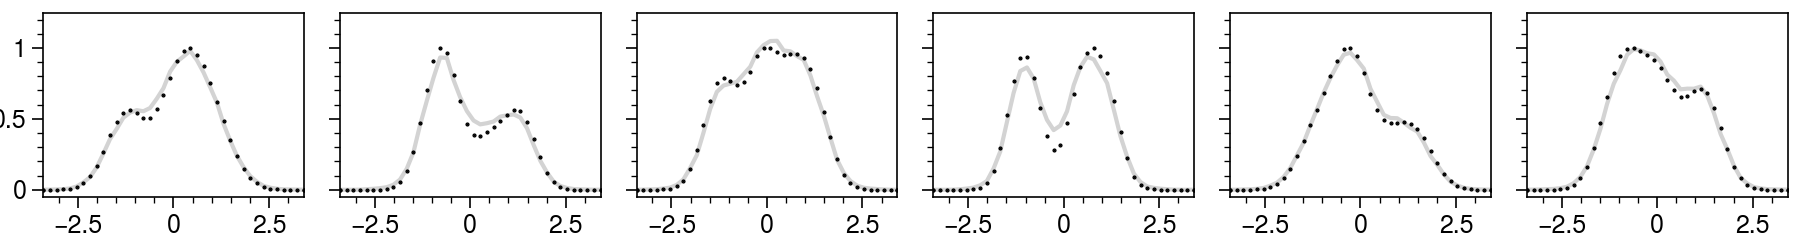

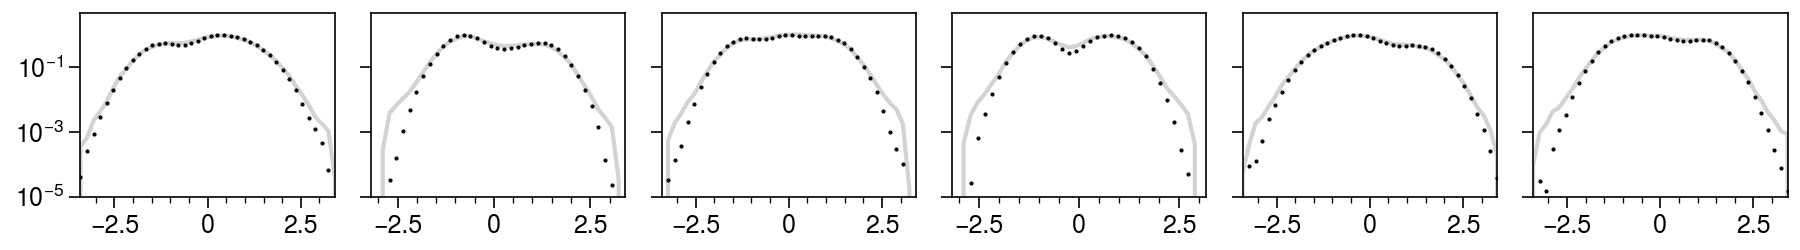

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|███▉                                                                                                                                                           | 350/14031 [00:00<00:03, 3493.89it/s]

  5%|███████▉                                                                                                                                                       | 700/14031 [00:00<00:03, 3491.20it/s]

  8%|███████████▉                                                                                                                                                  | 1055/14031 [00:00<00:03, 3513.98it/s]

 10%|███████████████▉                                                                                                                                              | 1411/14031 [00:00<00:03, 3530.94it/s]

 13%|███████████████████▉                                                                                                                                          | 1769/14031 [00:00<00:03, 3548.20it/s]

 15%|███████████████████████▉                                                                                                                                      | 2127/14031 [00:00<00:03, 3557.31it/s]

 18%|███████████████████████████▉                                                                                                                                  | 2483/14031 [00:00<00:03, 3557.20it/s]

 20%|███████████████████████████████▉                                                                                                                              | 2839/14031 [00:00<00:03, 3533.36it/s]

 23%|███████████████████████████████████▉                                                                                                                          | 3193/14031 [00:00<00:03, 3524.70it/s]

 25%|███████████████████████████████████████▉                                                                                                                      | 3549/14031 [00:01<00:02, 3534.59it/s]

 28%|███████████████████████████████████████████▉                                                                                                                  | 3906/14031 [00:01<00:02, 3544.35it/s]

 30%|████████████████████████████████████████████████                                                                                                              | 4264/14031 [00:01<00:02, 3553.28it/s]

 33%|████████████████████████████████████████████████████                                                                                                          | 4620/14031 [00:01<00:02, 3550.39it/s]

 35%|████████████████████████████████████████████████████████                                                                                                      | 4978/14031 [00:01<00:02, 3557.31it/s]

 38%|████████████████████████████████████████████████████████████                                                                                                  | 5338/14031 [00:01<00:02, 3568.57it/s]

 41%|████████████████████████████████████████████████████████████████▏                                                                                             | 5696/14031 [00:01<00:02, 3569.21it/s]

 43%|████████████████████████████████████████████████████████████████████▏                                                                                         | 6055/14031 [00:01<00:02, 3573.99it/s]

 46%|████████████████████████████████████████████████████████████████████████▏                                                                                     | 6415/14031 [00:01<00:02, 3579.56it/s]

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                 | 6776/14031 [00:01<00:02, 3586.97it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                             | 7135/14031 [00:02<00:01, 3587.47it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 7495/14031 [00:02<00:01, 3588.28it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 7854/14031 [00:02<00:01, 3588.57it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 8215/14031 [00:02<00:01, 3593.31it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 8576/14031 [00:02<00:01, 3596.40it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 8936/14031 [00:02<00:01, 3593.06it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 9296/14031 [00:02<00:01, 3590.69it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 9656/14031 [00:02<00:01, 3511.33it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 10008/14031 [00:02<00:01, 3499.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 10366/14031 [00:02<00:01, 3520.62it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 10727/14031 [00:03<00:00, 3545.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 11088/14031 [00:03<00:00, 3562.50it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 11447/14031 [00:03<00:00, 3570.41it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 11805/14031 [00:03<00:00, 3551.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 12161/14031 [00:03<00:00, 3535.20it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 12518/14031 [00:03<00:00, 3543.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 12875/14031 [00:03<00:00, 3550.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 13231/14031 [00:03<00:00, 3506.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 13584/14031 [00:03<00:00, 3511.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 13938/14031 [00:03<00:00, 3517.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3548.95it/s]

{'mean_abs_error': np.float64(0.010002708811625818)}
epoch = 2
transform=0
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 357/12015 [00:00<00:03, 3561.13it/s]

  6%|█████████▍                                                                                                                                                     | 714/12015 [00:00<00:03, 3561.98it/s]

  9%|██████████████                                                                                                                                                | 1072/12015 [00:00<00:03, 3565.71it/s]

 12%|██████████████████▊                                                                                                                                           | 1430/12015 [00:00<00:02, 3567.69it/s]

 15%|███████████████████████▍                                                                                                                                      | 1787/12015 [00:00<00:02, 3541.25it/s]

 18%|████████████████████████████▏                                                                                                                                 | 2142/12015 [00:00<00:02, 3521.88it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2495/12015 [00:00<00:02, 3522.27it/s]

 24%|█████████████████████████████████████▍                                                                                                                        | 2851/12015 [00:00<00:02, 3531.50it/s]

 27%|██████████████████████████████████████████▏                                                                                                                   | 3205/12015 [00:00<00:02, 3526.90it/s]

 30%|██████████████████████████████████████████████▊                                                                                                               | 3558/12015 [00:01<00:02, 3517.63it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                          | 3910/12015 [00:01<00:02, 3474.66it/s]

 35%|███████████████████████████████████████████████████████▉                                                                                                      | 4258/12015 [00:01<00:02, 3455.16it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                 | 4613/12015 [00:01<00:02, 3483.40it/s]

 41%|█████████████████████████████████████████████████████████████████▎                                                                                            | 4971/12015 [00:01<00:02, 3510.88it/s]

 44%|██████████████████████████████████████████████████████████████████████                                                                                        | 5328/12015 [00:01<00:01, 3527.48it/s]

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                   | 5685/12015 [00:01<00:01, 3540.10it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▍                                                                              | 6045/12015 [00:01<00:01, 3555.28it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 6401/12015 [00:01<00:01, 3541.99it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6761/12015 [00:01<00:01, 3557.04it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 7120/12015 [00:02<00:01, 3565.84it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 7480/12015 [00:02<00:01, 3574.34it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7839/12015 [00:02<00:01, 3576.56it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8198/12015 [00:02<00:01, 3580.04it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8557/12015 [00:02<00:00, 3576.93it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8915/12015 [00:02<00:00, 3575.52it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 9273/12015 [00:02<00:00, 3576.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 9638/12015 [00:02<00:00, 3597.76it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 10004/12015 [00:02<00:00, 3615.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 10368/12015 [00:02<00:00, 3620.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10731/12015 [00:03<00:00, 3618.37it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 11093/12015 [00:03<00:00, 3616.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 11455/12015 [00:03<00:00, 3602.39it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11816/12015 [00:03<00:00, 3576.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3555.87it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 357/12015 [00:00<00:03, 3566.87it/s]

  6%|█████████▍                                                                                                                                                     | 714/12015 [00:00<00:03, 3563.78it/s]

  9%|██████████████                                                                                                                                                | 1071/12015 [00:00<00:03, 3560.76it/s]

 12%|██████████████████▊                                                                                                                                           | 1429/12015 [00:00<00:02, 3567.00it/s]

 15%|███████████████████████▍                                                                                                                                      | 1786/12015 [00:00<00:02, 3541.26it/s]

 18%|████████████████████████████▏                                                                                                                                 | 2141/12015 [00:00<00:02, 3529.64it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2494/12015 [00:00<00:02, 3519.87it/s]

 24%|█████████████████████████████████████▍                                                                                                                        | 2850/12015 [00:00<00:02, 3531.41it/s]

 27%|██████████████████████████████████████████▏                                                                                                                   | 3204/12015 [00:00<00:02, 3533.74it/s]

 30%|██████████████████████████████████████████████▊                                                                                                               | 3561/12015 [00:01<00:02, 3542.30it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                          | 3916/12015 [00:01<00:02, 3543.43it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                     | 4272/12015 [00:01<00:02, 3546.16it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                                 | 4631/12015 [00:01<00:02, 3557.19it/s]

 42%|█████████████████████████████████████████████████████████████████▌                                                                                            | 4987/12015 [00:01<00:01, 3545.02it/s]

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                       | 5344/12015 [00:01<00:01, 3549.06it/s]

 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                   | 5703/12015 [00:01<00:01, 3560.74it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6061/12015 [00:01<00:01, 3565.09it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 6418/12015 [00:01<00:01, 3564.10it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 6778/12015 [00:01<00:01, 3572.03it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7138/12015 [00:02<00:01, 3577.62it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 7498/12015 [00:02<00:01, 3582.63it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 7857/12015 [00:02<00:01, 3583.79it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 8218/12015 [00:02<00:01, 3589.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8577/12015 [00:02<00:00, 3586.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 8936/12015 [00:02<00:00, 3587.58it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 9295/12015 [00:02<00:00, 3585.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 9654/12015 [00:02<00:00, 3580.40it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 10020/12015 [00:02<00:00, 3602.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10385/12015 [00:02<00:00, 3616.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 10747/12015 [00:03<00:00, 3602.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11108/12015 [00:03<00:00, 3604.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 11469/12015 [00:03<00:00, 3598.17it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11835/12015 [00:03<00:00, 3613.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3573.59it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▊                                                                                                                                                          | 359/12015 [00:00<00:03, 3582.44it/s]

  6%|█████████▌                                                                                                                                                     | 718/12015 [00:00<00:03, 3545.64it/s]

  9%|██████████████▏                                                                                                                                               | 1076/12015 [00:00<00:03, 3560.14it/s]

 12%|██████████████████▊                                                                                                                                           | 1433/12015 [00:00<00:02, 3543.52it/s]

 15%|███████████████████████▌                                                                                                                                      | 1794/12015 [00:00<00:02, 3563.30it/s]

 18%|████████████████████████████▎                                                                                                                                 | 2155/12015 [00:00<00:02, 3577.57it/s]

 21%|█████████████████████████████████                                                                                                                             | 2514/12015 [00:00<00:02, 3580.09it/s]

 24%|█████████████████████████████████████▊                                                                                                                        | 2873/12015 [00:00<00:02, 3559.74it/s]

 27%|██████████████████████████████████████████▍                                                                                                                   | 3230/12015 [00:00<00:02, 3540.13it/s]

 30%|███████████████████████████████████████████████▏                                                                                                              | 3588/12015 [00:01<00:02, 3550.01it/s]

 33%|███████████████████████████████████████████████████▉                                                                                                          | 3947/12015 [00:01<00:02, 3560.35it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                     | 4305/12015 [00:01<00:02, 3565.28it/s]

 39%|█████████████████████████████████████████████████████████████▎                                                                                                | 4665/12015 [00:01<00:02, 3573.46it/s]

 42%|██████████████████████████████████████████████████████████████████                                                                                            | 5025/12015 [00:01<00:01, 3580.71it/s]

 45%|██████████████████████████████████████████████████████████████████████▊                                                                                       | 5387/12015 [00:01<00:01, 3590.12it/s]

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                  | 5747/12015 [00:01<00:01, 3589.36it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                             | 6106/12015 [00:01<00:01, 3557.66it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                         | 6464/12015 [00:01<00:01, 3563.26it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 6824/12015 [00:01<00:01, 3572.22it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 7184/12015 [00:02<00:01, 3577.74it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7543/12015 [00:02<00:01, 3580.31it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7902/12015 [00:02<00:01, 3546.72it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 8261/12015 [00:02<00:01, 3558.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8621/12015 [00:02<00:00, 3570.94it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8982/12015 [00:02<00:00, 3579.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 9342/12015 [00:02<00:00, 3584.39it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 9703/12015 [00:02<00:00, 3589.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10064/12015 [00:02<00:00, 3593.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 10425/12015 [00:02<00:00, 3596.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 10785/12015 [00:03<00:00, 3595.50it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 11145/12015 [00:03<00:00, 3590.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 11505/12015 [00:03<00:00, 3591.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 11865/12015 [00:03<00:00, 3583.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3573.81it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 358/12015 [00:00<00:03, 3574.38it/s]

  6%|█████████▍                                                                                                                                                     | 716/12015 [00:00<00:03, 3570.86it/s]

  9%|██████████████                                                                                                                                                | 1074/12015 [00:00<00:03, 3555.81it/s]

 12%|██████████████████▊                                                                                                                                           | 1432/12015 [00:00<00:02, 3564.29it/s]

 15%|███████████████████████▌                                                                                                                                      | 1789/12015 [00:00<00:02, 3539.07it/s]

 18%|████████████████████████████▏                                                                                                                                 | 2147/12015 [00:00<00:02, 3551.03it/s]

 21%|████████████████████████████████▉                                                                                                                             | 2503/12015 [00:00<00:02, 3548.47it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 2861/12015 [00:00<00:02, 3557.11it/s]

 27%|██████████████████████████████████████████▎                                                                                                                   | 3220/12015 [00:00<00:02, 3567.19it/s]

 30%|███████████████████████████████████████████████                                                                                                               | 3577/12015 [00:01<00:02, 3563.12it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                          | 3934/12015 [00:01<00:02, 3563.20it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4291/12015 [00:01<00:02, 3559.59it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                                 | 4647/12015 [00:01<00:02, 3558.35it/s]

 42%|█████████████████████████████████████████████████████████████████▊                                                                                            | 5006/12015 [00:01<00:01, 3566.40it/s]

 45%|██████████████████████████████████████████████████████████████████████▌                                                                                       | 5363/12015 [00:01<00:01, 3546.15it/s]

 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                  | 5720/12015 [00:01<00:01, 3552.96it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                              | 6079/12015 [00:01<00:01, 3563.22it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 6437/12015 [00:01<00:01, 3565.97it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 6794/12015 [00:01<00:01, 3561.07it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                | 7153/12015 [00:02<00:01, 3566.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7510/12015 [00:02<00:01, 3561.57it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 7867/12015 [00:02<00:01, 3552.90it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 8225/12015 [00:02<00:01, 3557.68it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8581/12015 [00:02<00:00, 3554.80it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 8937/12015 [00:02<00:00, 3523.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 9290/12015 [00:02<00:00, 3501.09it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 9647/12015 [00:02<00:00, 3521.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 10002/12015 [00:02<00:00, 3528.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 10360/12015 [00:02<00:00, 3541.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 10719/12015 [00:03<00:00, 3553.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 11075/12015 [00:03<00:00, 3536.00it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11429/12015 [00:03<00:00, 3526.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 11782/12015 [00:03<00:00, 3526.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3547.10it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▊                                                                                                                                                          | 359/12015 [00:00<00:03, 3589.53it/s]

  6%|█████████▌                                                                                                                                                     | 719/12015 [00:00<00:03, 3591.09it/s]

  9%|██████████████▏                                                                                                                                               | 1079/12015 [00:00<00:03, 3548.62it/s]

 12%|██████████████████▉                                                                                                                                           | 1438/12015 [00:00<00:02, 3562.09it/s]

 15%|███████████████████████▋                                                                                                                                      | 1798/12015 [00:00<00:02, 3572.81it/s]

 18%|████████████████████████████▎                                                                                                                                 | 2156/12015 [00:00<00:02, 3574.94it/s]

 21%|█████████████████████████████████                                                                                                                             | 2514/12015 [00:00<00:02, 3570.84it/s]

 24%|█████████████████████████████████████▊                                                                                                                        | 2872/12015 [00:00<00:02, 3549.05it/s]

 27%|██████████████████████████████████████████▍                                                                                                                   | 3227/12015 [00:00<00:02, 3525.76it/s]

 30%|███████████████████████████████████████████████▏                                                                                                              | 3584/12015 [00:01<00:02, 3537.28it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                          | 3938/12015 [00:01<00:02, 3509.73it/s]

 36%|████████████████████████████████████████████████████████▍                                                                                                     | 4290/12015 [00:01<00:02, 3512.41it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                                 | 4642/12015 [00:01<00:02, 3500.69it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4993/12015 [00:01<00:02, 3500.26it/s]

 45%|██████████████████████████████████████████████████████████████████████▎                                                                                       | 5349/12015 [00:01<00:01, 3515.28it/s]

 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                   | 5701/12015 [00:01<00:01, 3499.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6056/12015 [00:01<00:01, 3512.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 6413/12015 [00:01<00:01, 3528.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                     | 6771/12015 [00:01<00:01, 3543.60it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7130/12015 [00:02<00:01, 3555.02it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7487/12015 [00:02<00:01, 3558.68it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 7845/12015 [00:02<00:01, 3563.02it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 8204/12015 [00:02<00:01, 3568.67it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8561/12015 [00:02<00:00, 3567.09it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8919/12015 [00:02<00:00, 3569.59it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 9276/12015 [00:02<00:00, 3568.94it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 9633/12015 [00:02<00:00, 3568.40it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 9991/12015 [00:02<00:00, 3569.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 10349/12015 [00:02<00:00, 3570.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10708/12015 [00:03<00:00, 3575.32it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 11066/12015 [00:03<00:00, 3575.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11424/12015 [00:03<00:00, 3576.25it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 11783/12015 [00:03<00:00, 3578.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3552.22it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▊                                                                                                                                                          | 361/12015 [00:00<00:03, 3600.49it/s]

  6%|█████████▌                                                                                                                                                     | 722/12015 [00:00<00:03, 3479.50it/s]

  9%|██████████████                                                                                                                                                | 1071/12015 [00:00<00:03, 3418.51it/s]

 12%|██████████████████▋                                                                                                                                           | 1424/12015 [00:00<00:03, 3457.82it/s]

 15%|███████████████████████▍                                                                                                                                      | 1781/12015 [00:00<00:02, 3496.30it/s]

 18%|████████████████████████████                                                                                                                                  | 2131/12015 [00:00<00:02, 3496.62it/s]

 21%|████████████████████████████████▋                                                                                                                             | 2481/12015 [00:00<00:02, 3492.56it/s]

 24%|█████████████████████████████████████▎                                                                                                                        | 2839/12015 [00:00<00:02, 3519.21it/s]

 27%|█████████████████████████████████████████▉                                                                                                                    | 3191/12015 [00:00<00:02, 3508.90it/s]

 29%|██████████████████████████████████████████████▌                                                                                                               | 3542/12015 [00:01<00:02, 3502.42it/s]

 32%|███████████████████████████████████████████████████▎                                                                                                          | 3903/12015 [00:01<00:02, 3532.23it/s]

 35%|████████████████████████████████████████████████████████                                                                                                      | 4265/12015 [00:01<00:02, 3557.57it/s]

 38%|████████████████████████████████████████████████████████████▊                                                                                                 | 4621/12015 [00:01<00:02, 3537.28it/s]

 41%|█████████████████████████████████████████████████████████████████▌                                                                                            | 4983/12015 [00:01<00:01, 3559.44it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                       | 5341/12015 [00:01<00:01, 3563.09it/s]

 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                   | 5699/12015 [00:01<00:01, 3565.82it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6061/12015 [00:01<00:01, 3580.80it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 6422/12015 [00:01<00:01, 3586.69it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 6782/12015 [00:01<00:01, 3590.44it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 7143/12015 [00:02<00:01, 3593.93it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7503/12015 [00:02<00:01, 3594.28it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 7863/12015 [00:02<00:01, 3594.79it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 8223/12015 [00:02<00:01, 3587.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8582/12015 [00:02<00:00, 3582.00it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 8941/12015 [00:02<00:00, 3583.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 9300/12015 [00:02<00:00, 3579.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 9658/12015 [00:02<00:00, 3577.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 10017/12015 [00:02<00:00, 3580.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 10376/12015 [00:02<00:00, 3573.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 10734/12015 [00:03<00:00, 3538.27it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 11088/12015 [00:03<00:00, 3531.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11442/12015 [00:03<00:00, 3519.63it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 11795/12015 [00:03<00:00, 3521.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3546.27it/s]

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|███▉                                                                                                                                                           | 347/14031 [00:00<00:03, 3460.17it/s]

  5%|███████▉                                                                                                                                                       | 701/14031 [00:00<00:03, 3506.66it/s]

  8%|███████████▉                                                                                                                                                  | 1056/14031 [00:00<00:03, 3524.81it/s]

 10%|███████████████▉                                                                                                                                              | 1411/14031 [00:00<00:03, 3531.86it/s]

 13%|███████████████████▉                                                                                                                                          | 1765/14031 [00:00<00:03, 3533.79it/s]

 15%|███████████████████████▊                                                                                                                                      | 2120/14031 [00:00<00:03, 3536.86it/s]

 18%|███████████████████████████▉                                                                                                                                  | 2476/14031 [00:00<00:03, 3542.63it/s]

 20%|███████████████████████████████▉                                                                                                                              | 2831/14031 [00:00<00:03, 3542.33it/s]

 23%|███████████████████████████████████▉                                                                                                                          | 3187/14031 [00:00<00:03, 3545.76it/s]

 25%|███████████████████████████████████████▉                                                                                                                      | 3542/14031 [00:01<00:02, 3545.45it/s]

 28%|███████████████████████████████████████████▉                                                                                                                  | 3897/14031 [00:01<00:02, 3545.38it/s]

 30%|███████████████████████████████████████████████▉                                                                                                              | 4253/14031 [00:01<00:02, 3548.60it/s]

 33%|███████████████████████████████████████████████████▉                                                                                                          | 4608/14031 [00:01<00:02, 3543.89it/s]

 35%|███████████████████████████████████████████████████████▉                                                                                                      | 4965/14031 [00:01<00:02, 3550.48it/s]

 38%|███████████████████████████████████████████████████████████▉                                                                                                  | 5322/14031 [00:01<00:02, 3553.42it/s]

 40%|███████████████████████████████████████████████████████████████▉                                                                                              | 5678/14031 [00:01<00:02, 3555.11it/s]

 43%|███████████████████████████████████████████████████████████████████▉                                                                                          | 6035/14031 [00:01<00:02, 3558.96it/s]

 46%|████████████████████████████████████████████████████████████████████████                                                                                      | 6394/14031 [00:01<00:02, 3565.47it/s]

 48%|████████████████████████████████████████████████████████████████████████████                                                                                  | 6753/14031 [00:01<00:02, 3571.83it/s]

 51%|████████████████████████████████████████████████████████████████████████████████                                                                              | 7111/14031 [00:02<00:01, 3571.51it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████                                                                          | 7469/14031 [00:02<00:01, 3565.85it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 7826/14031 [00:02<00:01, 3560.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 8183/14031 [00:02<00:01, 3555.02it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 8543/14031 [00:02<00:01, 3567.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 8900/14031 [00:02<00:01, 3563.63it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 9258/14031 [00:02<00:01, 3566.04it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 9615/14031 [00:02<00:01, 3541.29it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 9970/14031 [00:02<00:01, 3543.22it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 10325/14031 [00:02<00:01, 3545.17it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 10682/14031 [00:03<00:00, 3549.62it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 11041/14031 [00:03<00:00, 3558.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 11401/14031 [00:03<00:00, 3568.74it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 11758/14031 [00:03<00:00, 3566.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 12117/14031 [00:03<00:00, 3572.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 12475/14031 [00:03<00:00, 3572.08it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 12833/14031 [00:03<00:00, 3571.36it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 13191/14031 [00:03<00:00, 3572.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 13549/14031 [00:03<00:00, 3572.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 13907/14031 [00:03<00:00, 3573.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3556.07it/s]

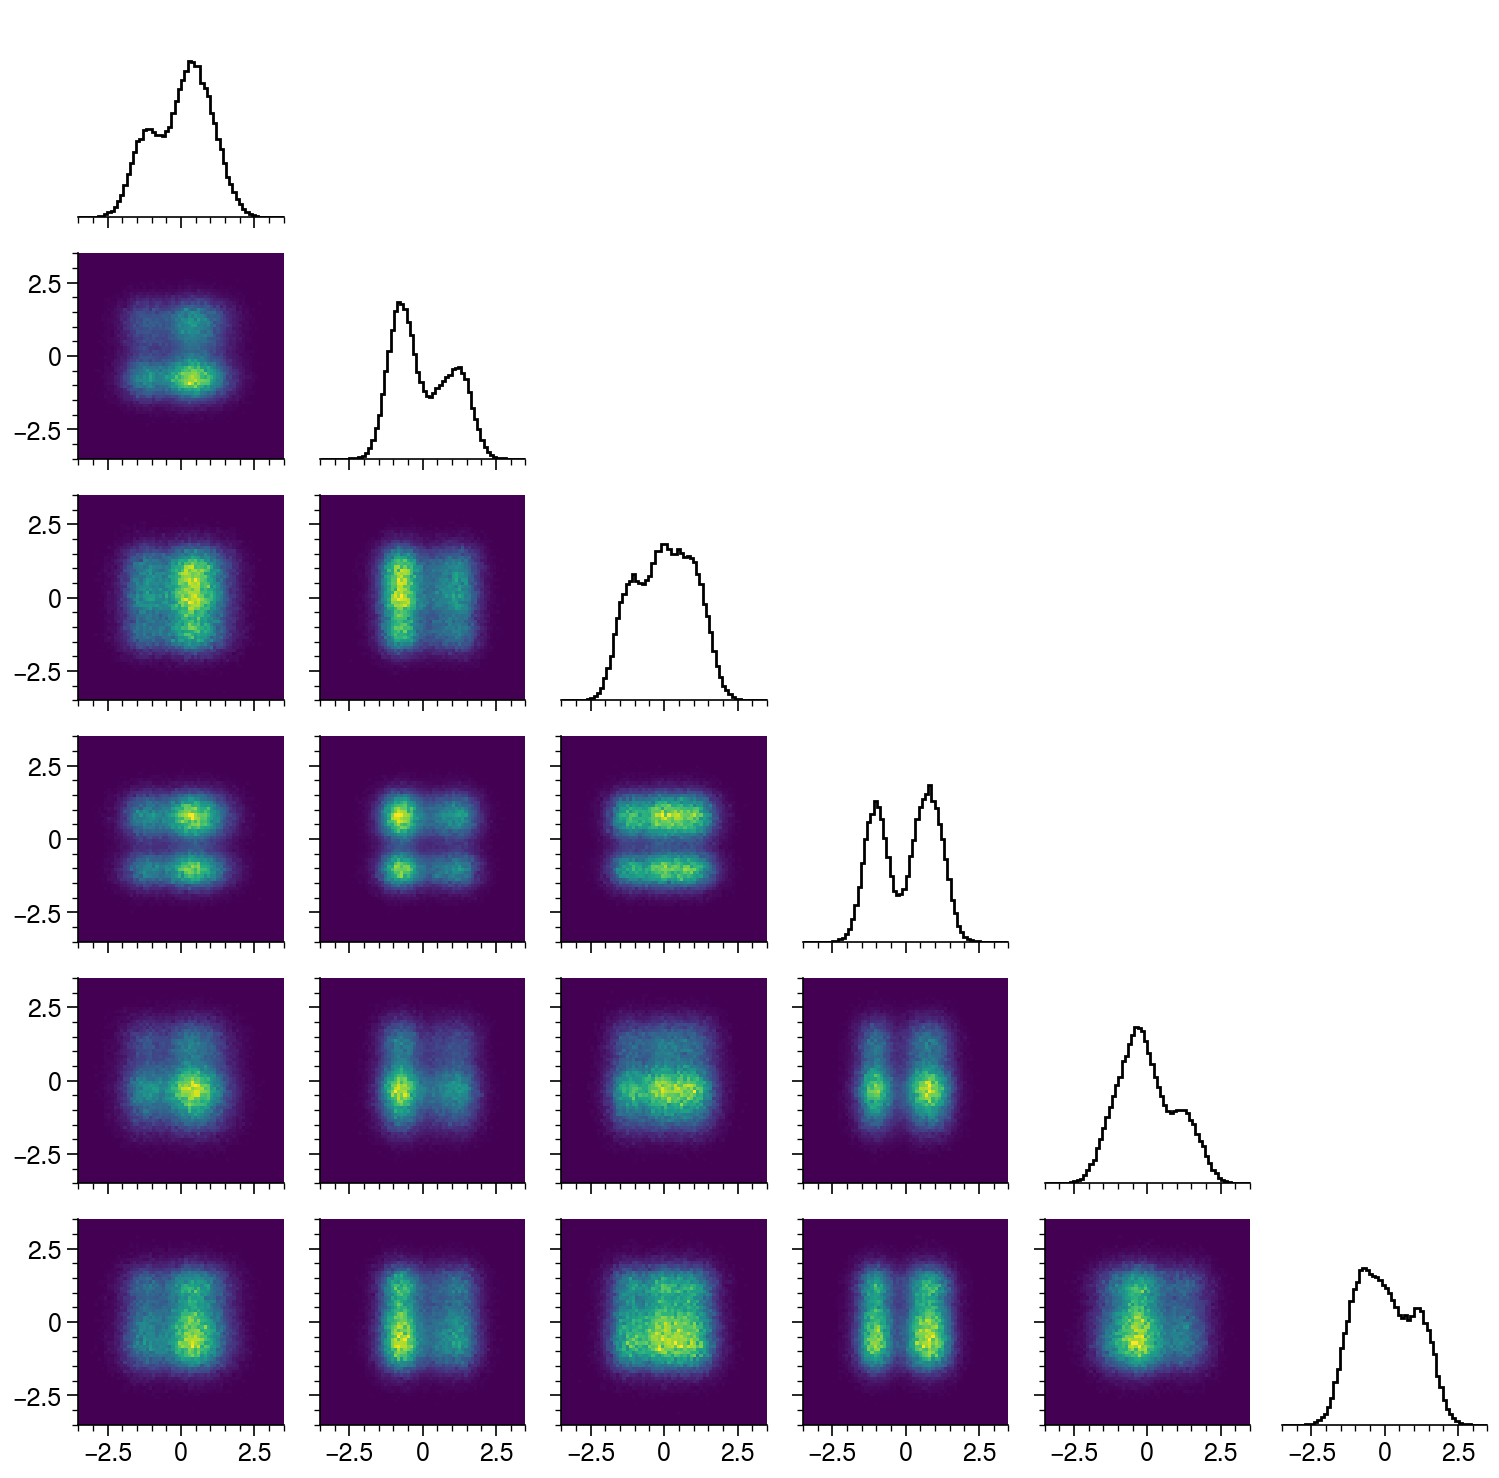

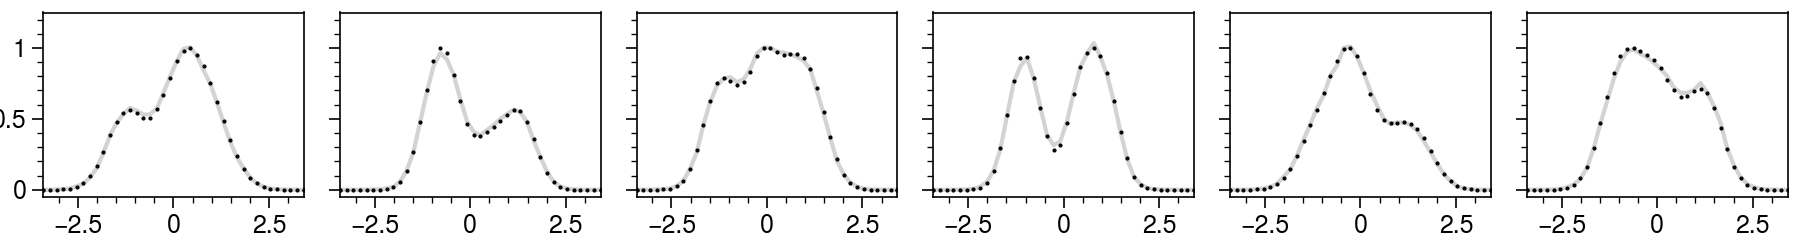

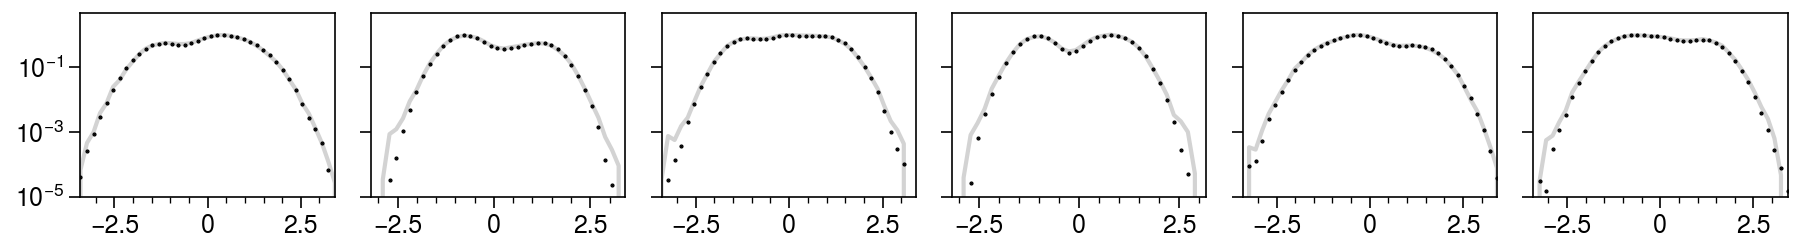

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  3%|████                                                                                                                                                           | 355/14031 [00:00<00:03, 3543.97it/s]

  5%|████████                                                                                                                                                       | 712/14031 [00:00<00:03, 3555.62it/s]

  8%|████████████                                                                                                                                                  | 1068/14031 [00:00<00:03, 3555.71it/s]

 10%|████████████████                                                                                                                                              | 1424/14031 [00:00<00:03, 3525.53it/s]

 13%|████████████████████                                                                                                                                          | 1780/14031 [00:00<00:03, 3535.83it/s]

 15%|████████████████████████                                                                                                                                      | 2136/14031 [00:00<00:03, 3542.87it/s]

 18%|████████████████████████████                                                                                                                                  | 2495/14031 [00:00<00:03, 3555.97it/s]

 20%|████████████████████████████████                                                                                                                              | 2851/14031 [00:00<00:03, 3526.39it/s]

 23%|████████████████████████████████████                                                                                                                          | 3204/14031 [00:00<00:03, 3511.52it/s]

 25%|████████████████████████████████████████                                                                                                                      | 3556/14031 [00:01<00:02, 3505.70it/s]

 28%|████████████████████████████████████████████                                                                                                                  | 3912/14031 [00:01<00:02, 3519.98it/s]

 30%|████████████████████████████████████████████████                                                                                                              | 4268/14031 [00:01<00:02, 3531.96it/s]

 33%|████████████████████████████████████████████████████                                                                                                          | 4624/14031 [00:01<00:02, 3540.35it/s]

 35%|████████████████████████████████████████████████████████                                                                                                      | 4979/14031 [00:01<00:02, 3530.60it/s]

 38%|████████████████████████████████████████████████████████████                                                                                                  | 5337/14031 [00:01<00:02, 3542.14it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                              | 5692/14031 [00:01<00:02, 3522.76it/s]

 43%|████████████████████████████████████████████████████████████████████                                                                                          | 6048/14031 [00:01<00:02, 3532.97it/s]

 46%|████████████████████████████████████████████████████████████████████████▏                                                                                     | 6407/14031 [00:01<00:02, 3549.89it/s]

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                 | 6764/14031 [00:01<00:02, 3555.26it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                             | 7121/14031 [00:02<00:01, 3559.15it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 7479/14031 [00:02<00:01, 3564.81it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 7836/14031 [00:02<00:01, 3565.06it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 8193/14031 [00:02<00:01, 3539.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 8548/14031 [00:02<00:01, 3534.63it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 8902/14031 [00:02<00:01, 3524.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 9258/14031 [00:02<00:01, 3531.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 9621/14031 [00:02<00:01, 3558.84it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 9983/14031 [00:02<00:01, 3576.36it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 10348/14031 [00:02<00:01, 3596.29it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 10711/14031 [00:03<00:00, 3604.60it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 11072/14031 [00:03<00:00, 3572.01it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 11430/14031 [00:03<00:00, 3555.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 11786/14031 [00:03<00:00, 3531.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 12143/14031 [00:03<00:00, 3541.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 12498/14031 [00:03<00:00, 3523.48it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 12851/14031 [00:03<00:00, 3483.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 13200/14031 [00:03<00:00, 3466.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 13547/14031 [00:03<00:00, 3465.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 13905/14031 [00:03<00:00, 3498.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3534.67it/s]

{'mean_abs_error': np.float64(0.003539901984321034)}
epoch = 3
transform=0
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 352/12015 [00:00<00:03, 3517.29it/s]

  6%|█████████▎                                                                                                                                                     | 704/12015 [00:00<00:03, 3509.58it/s]

  9%|█████████████▉                                                                                                                                                | 1061/12015 [00:00<00:03, 3535.80it/s]

 12%|██████████████████▋                                                                                                                                           | 1418/12015 [00:00<00:02, 3545.89it/s]

 15%|███████████████████████▎                                                                                                                                      | 1773/12015 [00:00<00:02, 3483.11it/s]

 18%|████████████████████████████                                                                                                                                  | 2130/12015 [00:00<00:02, 3512.13it/s]

 21%|████████████████████████████████▋                                                                                                                             | 2486/12015 [00:00<00:02, 3526.67it/s]

 24%|█████████████████████████████████████▍                                                                                                                        | 2843/12015 [00:00<00:02, 3540.16it/s]

 27%|██████████████████████████████████████████                                                                                                                    | 3202/12015 [00:00<00:02, 3555.44it/s]

 30%|██████████████████████████████████████████████▊                                                                                                               | 3558/12015 [00:01<00:02, 3547.33it/s]

 33%|███████████████████████████████████████████████████▍                                                                                                          | 3916/12015 [00:01<00:02, 3556.67it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                     | 4272/12015 [00:01<00:02, 3545.98it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                                 | 4630/12015 [00:01<00:02, 3553.45it/s]

 41%|█████████████████████████████████████████████████████████████████▌                                                                                            | 4986/12015 [00:01<00:01, 3535.09it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                       | 5341/12015 [00:01<00:01, 3537.52it/s]

 47%|██████████████████████████████████████████████████████████████████████████▉                                                                                   | 5699/12015 [00:01<00:01, 3547.58it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6057/12015 [00:01<00:01, 3554.73it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 6415/12015 [00:01<00:01, 3562.20it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                     | 6773/12015 [00:01<00:01, 3566.18it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7131/12015 [00:02<00:01, 3567.94it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7488/12015 [00:02<00:01, 3551.39it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 7846/12015 [00:02<00:01, 3559.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8202/12015 [00:02<00:01, 3558.02it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8558/12015 [00:02<00:00, 3537.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8914/12015 [00:02<00:00, 3543.25it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 9269/12015 [00:02<00:00, 3539.47it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 9623/12015 [00:02<00:00, 3538.51it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 9980/12015 [00:02<00:00, 3546.38it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 10338/12015 [00:02<00:00, 3556.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 10696/12015 [00:03<00:00, 3563.15it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 11053/12015 [00:03<00:00, 3503.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 11404/12015 [00:03<00:00, 3503.01it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 11762/12015 [00:03<00:00, 3525.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3539.35it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 357/12015 [00:00<00:03, 3566.97it/s]

  6%|█████████▍                                                                                                                                                     | 714/12015 [00:00<00:03, 3501.18it/s]

  9%|██████████████                                                                                                                                                | 1066/12015 [00:00<00:03, 3505.66it/s]

 12%|██████████████████▋                                                                                                                                           | 1423/12015 [00:00<00:03, 3528.67it/s]

 15%|███████████████████████▎                                                                                                                                      | 1776/12015 [00:00<00:02, 3523.48it/s]

 18%|████████████████████████████                                                                                                                                  | 2135/12015 [00:00<00:02, 3544.24it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2494/12015 [00:00<00:02, 3558.97it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 2852/12015 [00:00<00:02, 3563.61it/s]

 27%|██████████████████████████████████████████▏                                                                                                                   | 3210/12015 [00:00<00:02, 3567.88it/s]

 30%|██████████████████████████████████████████████▉                                                                                                               | 3569/12015 [00:01<00:02, 3574.59it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                          | 3928/12015 [00:01<00:02, 3578.63it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4286/12015 [00:01<00:02, 3556.26it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                                 | 4642/12015 [00:01<00:02, 3551.02it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4998/12015 [00:01<00:01, 3540.06it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                       | 5356/12015 [00:01<00:01, 3551.99it/s]

 48%|███████████████████████████████████████████████████████████████████████████                                                                                   | 5712/12015 [00:01<00:01, 3553.47it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                              | 6072/12015 [00:01<00:01, 3566.58it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 6433/12015 [00:01<00:01, 3576.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 6791/12015 [00:01<00:01, 3577.65it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                | 7152/12015 [00:02<00:01, 3584.56it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7511/12015 [00:02<00:01, 3583.33it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7873/12015 [00:02<00:01, 3592.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 8233/12015 [00:02<00:01, 3580.42it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 8592/12015 [00:02<00:00, 3568.14it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8952/12015 [00:02<00:00, 3575.03it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 9310/12015 [00:02<00:00, 3572.12it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 9670/12015 [00:02<00:00, 3578.48it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 10028/12015 [00:02<00:00, 3575.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10386/12015 [00:02<00:00, 3574.07it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 10747/12015 [00:03<00:00, 3582.69it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 11106/12015 [00:03<00:00, 3580.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 11465/12015 [00:03<00:00, 3578.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11823/12015 [00:03<00:00, 3554.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3558.82it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 356/12015 [00:00<00:03, 3550.41it/s]

  6%|█████████▍                                                                                                                                                     | 714/12015 [00:00<00:03, 3562.19it/s]

  9%|██████████████                                                                                                                                                | 1072/12015 [00:00<00:03, 3567.92it/s]

 12%|██████████████████▊                                                                                                                                           | 1429/12015 [00:00<00:02, 3560.49it/s]

 15%|███████████████████████▍                                                                                                                                      | 1787/12015 [00:00<00:02, 3567.21it/s]

 18%|████████████████████████████▏                                                                                                                                 | 2144/12015 [00:00<00:02, 3561.63it/s]

 21%|████████████████████████████████▉                                                                                                                             | 2502/12015 [00:00<00:02, 3565.49it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 2860/12015 [00:00<00:02, 3569.67it/s]

 27%|██████████████████████████████████████████▎                                                                                                                   | 3217/12015 [00:00<00:02, 3564.73it/s]

 30%|███████████████████████████████████████████████                                                                                                               | 3577/12015 [00:01<00:02, 3573.42it/s]

 33%|███████████████████████████████████████████████████▊                                                                                                          | 3938/12015 [00:01<00:02, 3583.01it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                     | 4299/12015 [00:01<00:02, 3589.33it/s]

 39%|█████████████████████████████████████████████████████████████▎                                                                                                | 4658/12015 [00:01<00:02, 3585.52it/s]

 42%|█████████████████████████████████████████████████████████████████▉                                                                                            | 5017/12015 [00:01<00:01, 3586.52it/s]

 45%|██████████████████████████████████████████████████████████████████████▋                                                                                       | 5378/12015 [00:01<00:01, 3592.19it/s]

 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                  | 5738/12015 [00:01<00:01, 3587.55it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                             | 6098/12015 [00:01<00:01, 3589.78it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 6457/12015 [00:01<00:01, 3588.20it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 6817/12015 [00:01<00:01, 3590.23it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 7178/12015 [00:02<00:01, 3594.00it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7538/12015 [00:02<00:01, 3592.71it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 7898/12015 [00:02<00:01, 3590.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 8258/12015 [00:02<00:01, 3570.24it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8616/12015 [00:02<00:00, 3551.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8975/12015 [00:02<00:00, 3561.95it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 9332/12015 [00:02<00:00, 3549.34it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 9687/12015 [00:02<00:00, 3546.77it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 10047/12015 [00:02<00:00, 3560.37it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 10404/12015 [00:02<00:00, 3545.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 10759/12015 [00:03<00:00, 3536.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11115/12015 [00:03<00:00, 3540.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 11470/12015 [00:03<00:00, 3481.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11823/12015 [00:03<00:00, 3494.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3559.99it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 350/12015 [00:00<00:03, 3493.56it/s]

  6%|█████████▎                                                                                                                                                     | 705/12015 [00:00<00:03, 3521.60it/s]

  9%|█████████████▉                                                                                                                                                | 1062/12015 [00:00<00:03, 3542.80it/s]

 12%|██████████████████▋                                                                                                                                           | 1417/12015 [00:00<00:03, 3532.32it/s]

 15%|███████████████████████▎                                                                                                                                      | 1776/12015 [00:00<00:02, 3550.43it/s]

 18%|████████████████████████████                                                                                                                                  | 2136/12015 [00:00<00:02, 3563.98it/s]

 21%|████████████████████████████████▊                                                                                                                             | 2495/12015 [00:00<00:02, 3571.81it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 2855/12015 [00:00<00:02, 3579.59it/s]

 27%|██████████████████████████████████████████▎                                                                                                                   | 3213/12015 [00:00<00:02, 3558.43it/s]

 30%|██████████████████████████████████████████████▉                                                                                                               | 3571/12015 [00:01<00:02, 3564.40it/s]

 33%|███████████████████████████████████████████████████▋                                                                                                          | 3928/12015 [00:01<00:02, 3565.34it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4285/12015 [00:01<00:02, 3565.29it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                                 | 4642/12015 [00:01<00:02, 3565.37it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4999/12015 [00:01<00:01, 3547.95it/s]

 45%|██████████████████████████████████████████████████████████████████████▍                                                                                       | 5354/12015 [00:01<00:01, 3541.56it/s]

 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                  | 5713/12015 [00:01<00:01, 3554.03it/s]

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                              | 6074/12015 [00:01<00:01, 3569.76it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 6432/12015 [00:01<00:01, 3571.50it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 6790/12015 [00:01<00:01, 3554.72it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                | 7149/12015 [00:02<00:01, 3564.79it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7510/12015 [00:02<00:01, 3575.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7871/12015 [00:02<00:01, 3583.18it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 8233/12015 [00:02<00:01, 3591.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 8593/12015 [00:02<00:00, 3546.00it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8948/12015 [00:02<00:00, 3484.67it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 9305/12015 [00:02<00:00, 3507.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 9664/12015 [00:02<00:00, 3531.06it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 10023/12015 [00:02<00:00, 3547.26it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 10392/12015 [00:02<00:00, 3589.59it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 10752/12015 [00:03<00:00, 3576.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11110/12015 [00:03<00:00, 3570.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 11468/12015 [00:03<00:00, 3567.59it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11825/12015 [00:03<00:00, 3568.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3557.88it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▌                                                                                                                                                          | 349/12015 [00:00<00:03, 3489.37it/s]

  6%|█████████▎                                                                                                                                                     | 699/12015 [00:00<00:03, 3494.63it/s]

  9%|█████████████▉                                                                                                                                                | 1056/12015 [00:00<00:03, 3527.06it/s]

 12%|██████████████████▌                                                                                                                                           | 1409/12015 [00:00<00:03, 3521.47it/s]

 15%|███████████████████████▏                                                                                                                                      | 1768/12015 [00:00<00:02, 3544.56it/s]

 18%|███████████████████████████▉                                                                                                                                  | 2123/12015 [00:00<00:02, 3531.24it/s]

 21%|████████████████████████████████▌                                                                                                                             | 2477/12015 [00:00<00:02, 3526.65it/s]

 24%|█████████████████████████████████████▏                                                                                                                        | 2830/12015 [00:00<00:02, 3522.00it/s]

 27%|█████████████████████████████████████████▉                                                                                                                    | 3187/12015 [00:00<00:02, 3534.89it/s]

 30%|██████████████████████████████████████████████▌                                                                                                               | 3545/12015 [00:01<00:02, 3548.23it/s]

 32%|███████████████████████████████████████████████████▎                                                                                                          | 3903/12015 [00:01<00:02, 3555.11it/s]

 35%|████████████████████████████████████████████████████████                                                                                                      | 4260/12015 [00:01<00:02, 3559.32it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                 | 4616/12015 [00:01<00:02, 3538.41it/s]

 41%|█████████████████████████████████████████████████████████████████▍                                                                                            | 4974/12015 [00:01<00:01, 3549.73it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                       | 5334/12015 [00:01<00:01, 3562.00it/s]

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                   | 5691/12015 [00:01<00:01, 3545.16it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                              | 6048/12015 [00:01<00:01, 3550.95it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 6406/12015 [00:01<00:01, 3556.93it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6764/12015 [00:01<00:01, 3561.90it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 7123/12015 [00:02<00:01, 3568.79it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7481/12015 [00:02<00:01, 3570.85it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7840/12015 [00:02<00:01, 3575.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8199/12015 [00:02<00:01, 3577.14it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8558/12015 [00:02<00:00, 3579.80it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8919/12015 [00:02<00:00, 3587.13it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 9278/12015 [00:02<00:00, 3586.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 9637/12015 [00:02<00:00, 3581.76it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 9996/12015 [00:02<00:00, 3483.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 10349/12015 [00:02<00:00, 3495.25it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10707/12015 [00:03<00:00, 3519.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 11068/12015 [00:03<00:00, 3543.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11428/12015 [00:03<00:00, 3558.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 11786/12015 [00:03<00:00, 3564.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3550.08it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                                           | 0/12015 [00:00<?, ?it/s]

  3%|████▋                                                                                                                                                          | 351/12015 [00:00<00:03, 3507.75it/s]

  6%|█████████▍                                                                                                                                                     | 712/12015 [00:00<00:03, 3562.19it/s]

  9%|██████████████                                                                                                                                                | 1069/12015 [00:00<00:03, 3536.89it/s]

 12%|██████████████████▊                                                                                                                                           | 1430/12015 [00:00<00:02, 3562.67it/s]

 15%|███████████████████████▍                                                                                                                                      | 1787/12015 [00:00<00:02, 3549.46it/s]

 18%|████████████████████████████▏                                                                                                                                 | 2144/12015 [00:00<00:02, 3552.61it/s]

 21%|████████████████████████████████▉                                                                                                                             | 2500/12015 [00:00<00:02, 3550.40it/s]

 24%|█████████████████████████████████████▌                                                                                                                        | 2856/12015 [00:00<00:02, 3541.36it/s]

 27%|██████████████████████████████████████████▏                                                                                                                   | 3211/12015 [00:00<00:02, 3542.01it/s]

 30%|██████████████████████████████████████████████▉                                                                                                               | 3566/12015 [00:01<00:02, 3542.16it/s]

 33%|███████████████████████████████████████████████████▌                                                                                                          | 3925/12015 [00:01<00:02, 3555.76it/s]

 36%|████████████████████████████████████████████████████████▎                                                                                                     | 4281/12015 [00:01<00:02, 3548.63it/s]

 39%|████████████████████████████████████████████████████████████▉                                                                                                 | 4636/12015 [00:01<00:02, 3546.27it/s]

 42%|█████████████████████████████████████████████████████████████████▋                                                                                            | 4993/12015 [00:01<00:01, 3550.80it/s]

 45%|██████████████████████████████████████████████████████████████████████▎                                                                                       | 5349/12015 [00:01<00:01, 3545.44it/s]

 47%|███████████████████████████████████████████████████████████████████████████                                                                                   | 5707/12015 [00:01<00:01, 3553.50it/s]

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                              | 6063/12015 [00:01<00:01, 3554.29it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 6419/12015 [00:01<00:01, 3536.13it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                     | 6773/12015 [00:01<00:01, 3520.48it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7130/12015 [00:02<00:01, 3534.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7486/12015 [00:02<00:01, 3540.99it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7841/12015 [00:02<00:01, 3529.95it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8199/12015 [00:02<00:01, 3542.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8554/12015 [00:02<00:00, 3507.57it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 8905/12015 [00:02<00:00, 3467.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 9259/12015 [00:02<00:00, 3488.74it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 9617/12015 [00:02<00:00, 3513.03it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 9970/12015 [00:02<00:00, 3517.04it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 10322/12015 [00:02<00:00, 3511.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 10678/12015 [00:03<00:00, 3523.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 11031/12015 [00:03<00:00, 3518.24it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11389/12015 [00:03<00:00, 3534.94it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 11746/12015 [00:03<00:00, 3544.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3534.35it/s]

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|███▉                                                                                                                                                           | 342/14031 [00:00<00:04, 3413.07it/s]

  5%|███████▊                                                                                                                                                       | 686/14031 [00:00<00:03, 3424.95it/s]

  7%|███████████▋                                                                                                                                                  | 1035/14031 [00:00<00:03, 3452.05it/s]

 10%|███████████████▌                                                                                                                                              | 1386/14031 [00:00<00:03, 3472.64it/s]

 12%|███████████████████▌                                                                                                                                          | 1735/14031 [00:00<00:03, 3478.82it/s]

 15%|███████████████████████▍                                                                                                                                      | 2083/14031 [00:00<00:03, 3477.72it/s]

 17%|███████████████████████████▍                                                                                                                                  | 2432/14031 [00:00<00:03, 3479.79it/s]

 20%|███████████████████████████████▎                                                                                                                              | 2780/14031 [00:00<00:03, 3464.32it/s]

 22%|███████████████████████████████████▏                                                                                                                          | 3127/14031 [00:00<00:03, 3436.84it/s]

 25%|███████████████████████████████████████                                                                                                                       | 3471/14031 [00:01<00:03, 3419.64it/s]

 27%|██████████████████████████████████████████▉                                                                                                                   | 3818/14031 [00:01<00:02, 3433.75it/s]

 30%|██████████████████████████████████████████████▊                                                                                                               | 4162/14031 [00:01<00:02, 3406.44it/s]

 32%|██████████████████████████████████████████████████▋                                                                                                           | 4503/14031 [00:01<00:02, 3405.35it/s]

 35%|██████████████████████████████████████████████████████▌                                                                                                       | 4844/14031 [00:01<00:02, 3385.66it/s]

 37%|██████████████████████████████████████████████████████████▍                                                                                                   | 5184/14031 [00:01<00:02, 3387.50it/s]

 39%|██████████████████████████████████████████████████████████████▏                                                                                               | 5523/14031 [00:01<00:02, 3383.61it/s]

 42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 5875/14031 [00:01<00:02, 3422.96it/s]

 44%|██████████████████████████████████████████████████████████████████████                                                                                        | 6221/14031 [00:01<00:02, 3431.48it/s]

 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                    | 6565/14031 [00:01<00:02, 3429.32it/s]

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                | 6910/14031 [00:02<00:02, 3434.68it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                            | 7254/14031 [00:02<00:01, 3429.16it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 7599/14031 [00:02<00:01, 3433.56it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 7943/14031 [00:02<00:01, 3428.47it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 8286/14031 [00:02<00:01, 3387.61it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 8626/14031 [00:02<00:01, 3390.91it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 8966/14031 [00:02<00:01, 3379.35it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 9304/14031 [00:02<00:01, 3343.03it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 9639/14031 [00:02<00:01, 3299.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 9970/14031 [00:02<00:01, 3300.72it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 10309/14031 [00:03<00:01, 3325.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 10662/14031 [00:03<00:00, 3386.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 11016/14031 [00:03<00:00, 3431.02it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 11367/14031 [00:03<00:00, 3454.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 11722/14031 [00:03<00:00, 3480.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 12084/14031 [00:03<00:00, 3520.63it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 12438/14031 [00:03<00:00, 3524.27it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 12791/14031 [00:03<00:00, 3515.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 13143/14031 [00:03<00:00, 3506.96it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 13495/14031 [00:03<00:00, 3508.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 13847/14031 [00:04<00:00, 3512.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:04<00:00, 3434.51it/s]

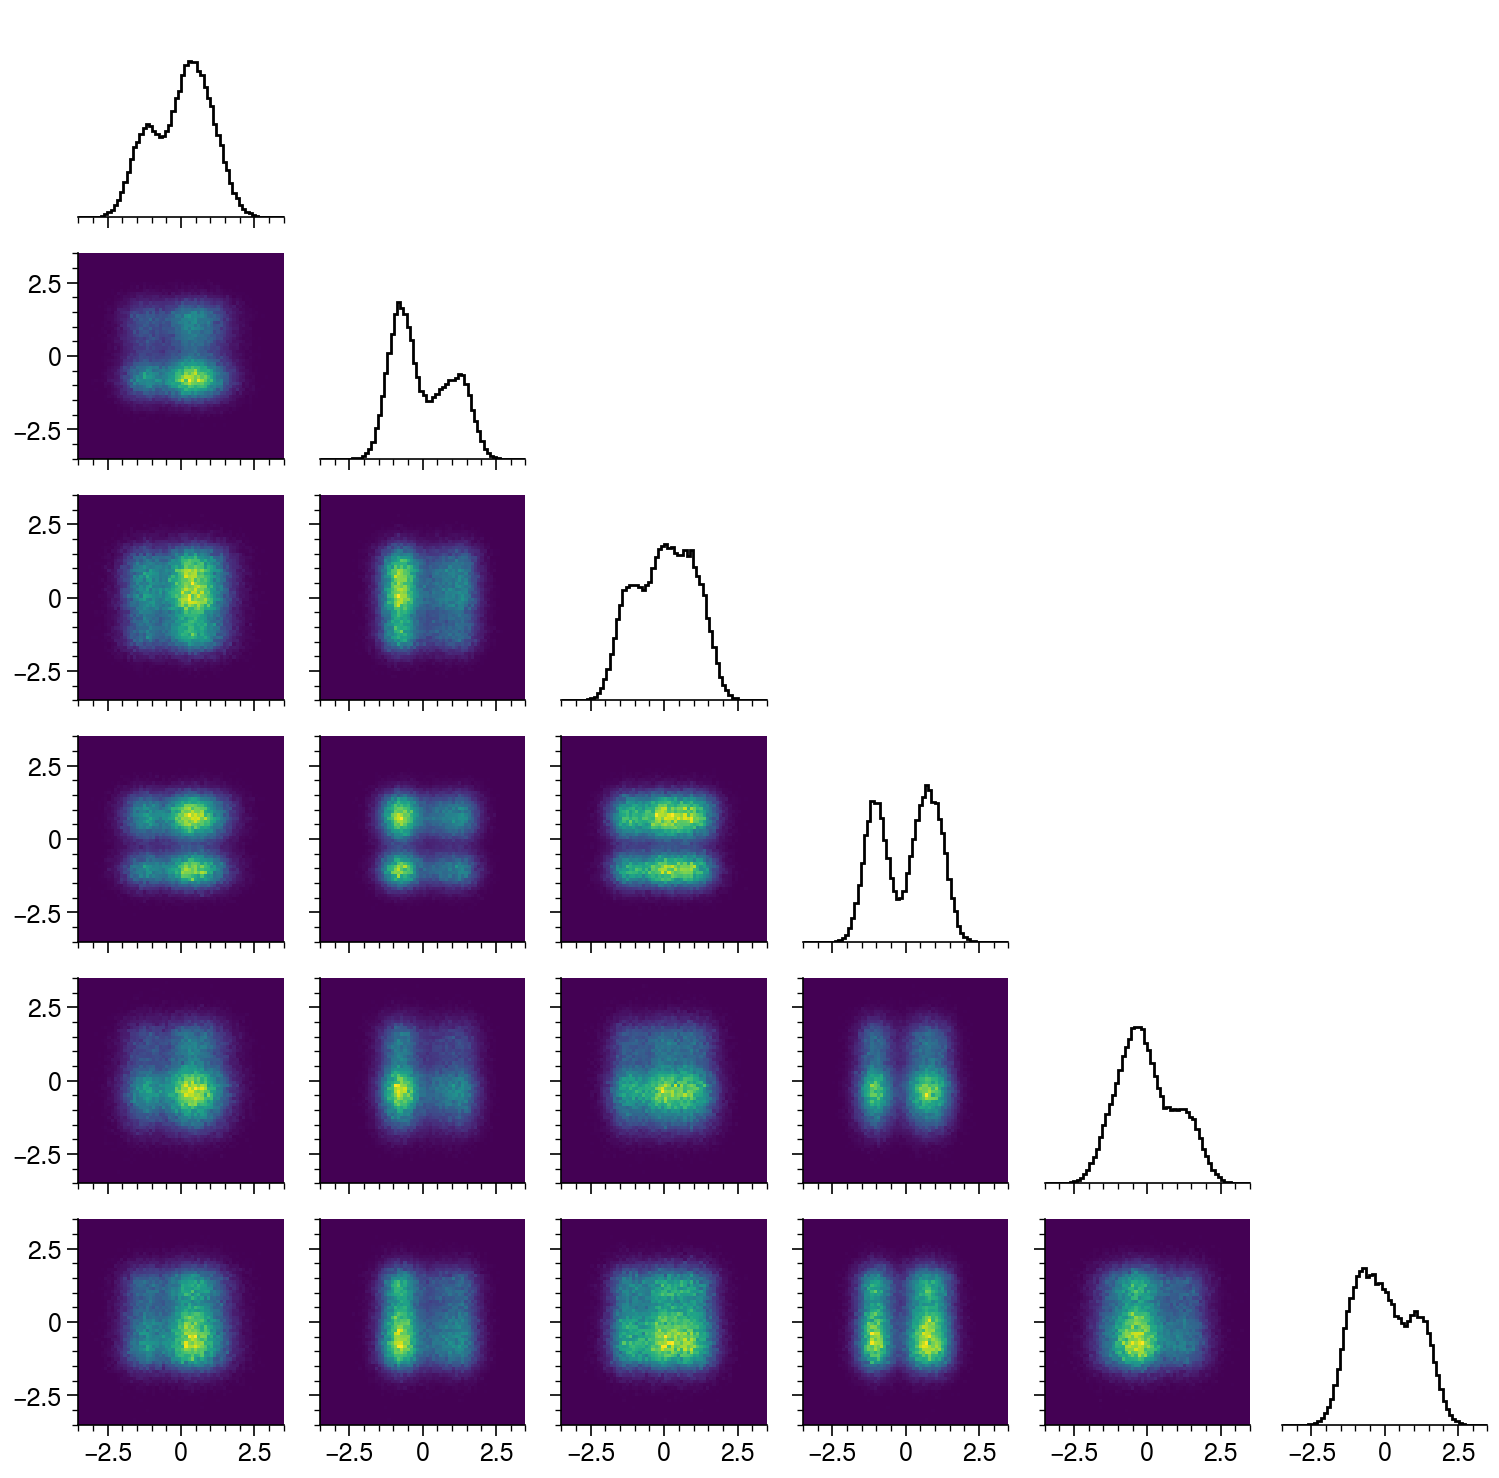

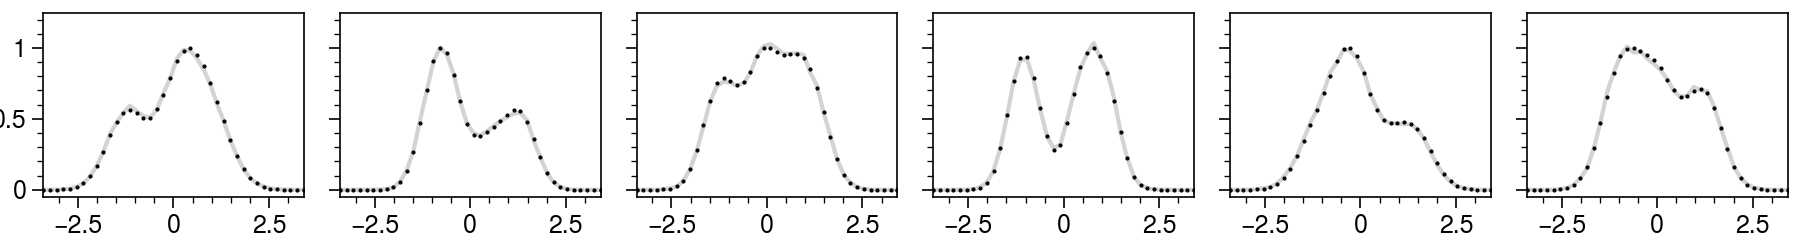

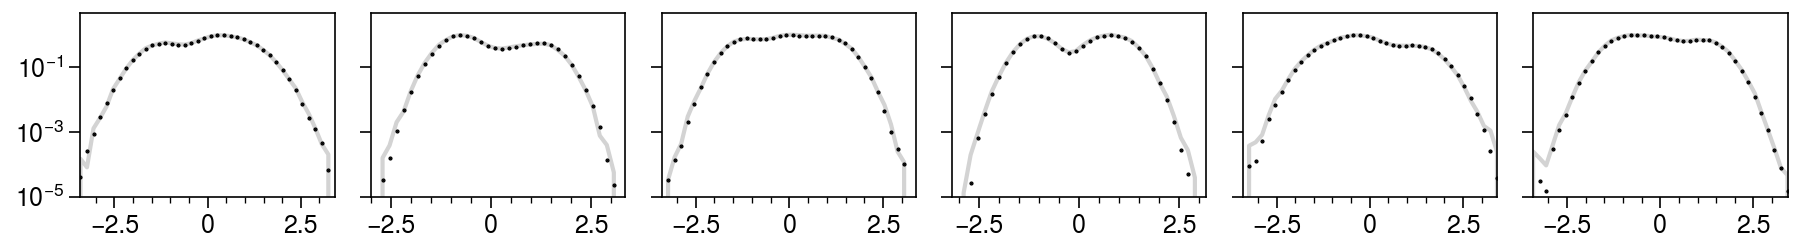

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  2%|███▊                                                                                                                                                           | 339/14031 [00:00<00:04, 3384.46it/s]

  5%|███████▊                                                                                                                                                       | 684/14031 [00:00<00:03, 3419.25it/s]

  7%|███████████▌                                                                                                                                                  | 1028/14031 [00:00<00:03, 3426.02it/s]

 10%|███████████████▍                                                                                                                                              | 1371/14031 [00:00<00:03, 3424.50it/s]

 12%|███████████████████▎                                                                                                                                          | 1715/14031 [00:00<00:03, 3429.99it/s]

 15%|███████████████████████▏                                                                                                                                      | 2062/14031 [00:00<00:03, 3441.77it/s]

 17%|███████████████████████████                                                                                                                                   | 2407/14031 [00:00<00:03, 3427.75it/s]

 20%|██████████████████████████████▉                                                                                                                               | 2750/14031 [00:00<00:03, 3420.80it/s]

 22%|██████████████████████████████████▊                                                                                                                           | 3093/14031 [00:00<00:03, 3416.82it/s]

 24%|██████████████████████████████████████▋                                                                                                                       | 3435/14031 [00:01<00:03, 3414.41it/s]

 27%|██████████████████████████████████████████▋                                                                                                                   | 3789/14031 [00:01<00:02, 3450.88it/s]

 29%|██████████████████████████████████████████████▌                                                                                                               | 4135/14031 [00:01<00:02, 3444.07it/s]

 32%|██████████████████████████████████████████████████▍                                                                                                           | 4480/14031 [00:01<00:02, 3440.43it/s]

 34%|██████████████████████████████████████████████████████▎                                                                                                       | 4828/14031 [00:01<00:02, 3450.82it/s]

 37%|██████████████████████████████████████████████████████████▎                                                                                                   | 5179/14031 [00:01<00:02, 3466.69it/s]

 39%|██████████████████████████████████████████████████████████████▎                                                                                               | 5532/14031 [00:01<00:02, 3483.02it/s]

 42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 5883/14031 [00:01<00:02, 3489.18it/s]

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                       | 6233/14031 [00:01<00:02, 3489.89it/s]

 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                   | 6584/14031 [00:01<00:02, 3494.43it/s]

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                | 6935/14031 [00:02<00:02, 3497.56it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████                                                                            | 7285/14031 [00:02<00:01, 3496.93it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                        | 7640/14031 [00:02<00:01, 3510.14it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 7992/14031 [00:02<00:01, 3510.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 8344/14031 [00:02<00:01, 3509.40it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 8695/14031 [00:02<00:01, 3508.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 9048/14031 [00:02<00:01, 3514.83it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 9400/14031 [00:02<00:01, 3511.45it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 9756/14031 [00:02<00:01, 3525.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 10109/14031 [00:02<00:01, 3519.01it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 10461/14031 [00:03<00:01, 3518.20it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 10813/14031 [00:03<00:00, 3513.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 11165/14031 [00:03<00:00, 3512.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 11517/14031 [00:03<00:00, 3511.28it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 11869/14031 [00:03<00:00, 3506.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 12220/14031 [00:03<00:00, 3504.62it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 12571/14031 [00:03<00:00, 3452.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 12917/14031 [00:03<00:00, 3445.31it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 13268/14031 [00:03<00:00, 3462.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 13627/14031 [00:03<00:00, 3497.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 13984/14031 [00:04<00:00, 3517.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:04<00:00, 3479.72it/s]

{'mean_abs_error': np.float64(0.0023291694873741353)}


In [11]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=eval_model,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)

## Evaluate

  0%|                                                                                                                                                                           | 0/14031 [00:00<?, ?it/s]

  3%|████                                                                                                                                                           | 358/14031 [00:00<00:03, 3575.67it/s]

  5%|████████                                                                                                                                                       | 716/14031 [00:00<00:03, 3576.26it/s]

  8%|████████████                                                                                                                                                  | 1075/14031 [00:00<00:03, 3578.74it/s]

 10%|████████████████▏                                                                                                                                             | 1433/14031 [00:00<00:03, 3574.98it/s]

 13%|████████████████████▏                                                                                                                                         | 1793/14031 [00:00<00:03, 3581.76it/s]

 15%|████████████████████████▏                                                                                                                                     | 2152/14031 [00:00<00:03, 3582.56it/s]

 18%|████████████████████████████▎                                                                                                                                 | 2511/14031 [00:00<00:03, 3579.65it/s]

 20%|████████████████████████████████▎                                                                                                                             | 2870/14031 [00:00<00:03, 3581.06it/s]

 23%|████████████████████████████████████▎                                                                                                                         | 3230/14031 [00:00<00:03, 3584.42it/s]

 26%|████████████████████████████████████████▍                                                                                                                     | 3591/14031 [00:01<00:02, 3589.85it/s]

 28%|████████████████████████████████████████████▍                                                                                                                 | 3951/14031 [00:01<00:02, 3592.80it/s]

 31%|████████████████████████████████████████████████▌                                                                                                             | 4311/14031 [00:01<00:02, 3593.51it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                         | 4671/14031 [00:01<00:02, 3593.89it/s]

 36%|████████████████████████████████████████████████████████▋                                                                                                     | 5031/14031 [00:01<00:02, 3587.08it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                 | 5390/14031 [00:01<00:02, 3585.38it/s]

 41%|████████████████████████████████████████████████████████████████▊                                                                                             | 5751/14031 [00:01<00:02, 3590.61it/s]

 44%|████████████████████████████████████████████████████████████████████▊                                                                                         | 6111/14031 [00:01<00:02, 3590.56it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                     | 6471/14031 [00:01<00:02, 3593.16it/s]

 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                 | 6832/14031 [00:01<00:02, 3595.55it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                             | 7192/14031 [00:02<00:01, 3589.21it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                         | 7551/14031 [00:02<00:01, 3586.78it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                     | 7910/14031 [00:02<00:01, 3584.06it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 8271/14031 [00:02<00:01, 3590.34it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 8631/14031 [00:02<00:01, 3587.55it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 8990/14031 [00:02<00:01, 3587.02it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 9349/14031 [00:02<00:01, 3553.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 9705/14031 [00:02<00:01, 3455.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 10059/14031 [00:02<00:01, 3477.61it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 10415/14031 [00:02<00:01, 3501.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 10774/14031 [00:03<00:00, 3525.27it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 11131/14031 [00:03<00:00, 3536.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 11489/14031 [00:03<00:00, 3547.44it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 11848/14031 [00:03<00:00, 3559.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 12205/14031 [00:03<00:00, 3553.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 12562/14031 [00:03<00:00, 3557.41it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 12921/14031 [00:03<00:00, 3565.24it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 13279/14031 [00:03<00:00, 3567.33it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 13636/14031 [00:03<00:00, 3566.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 13994/14031 [00:03<00:00, 3568.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3567.36it/s]

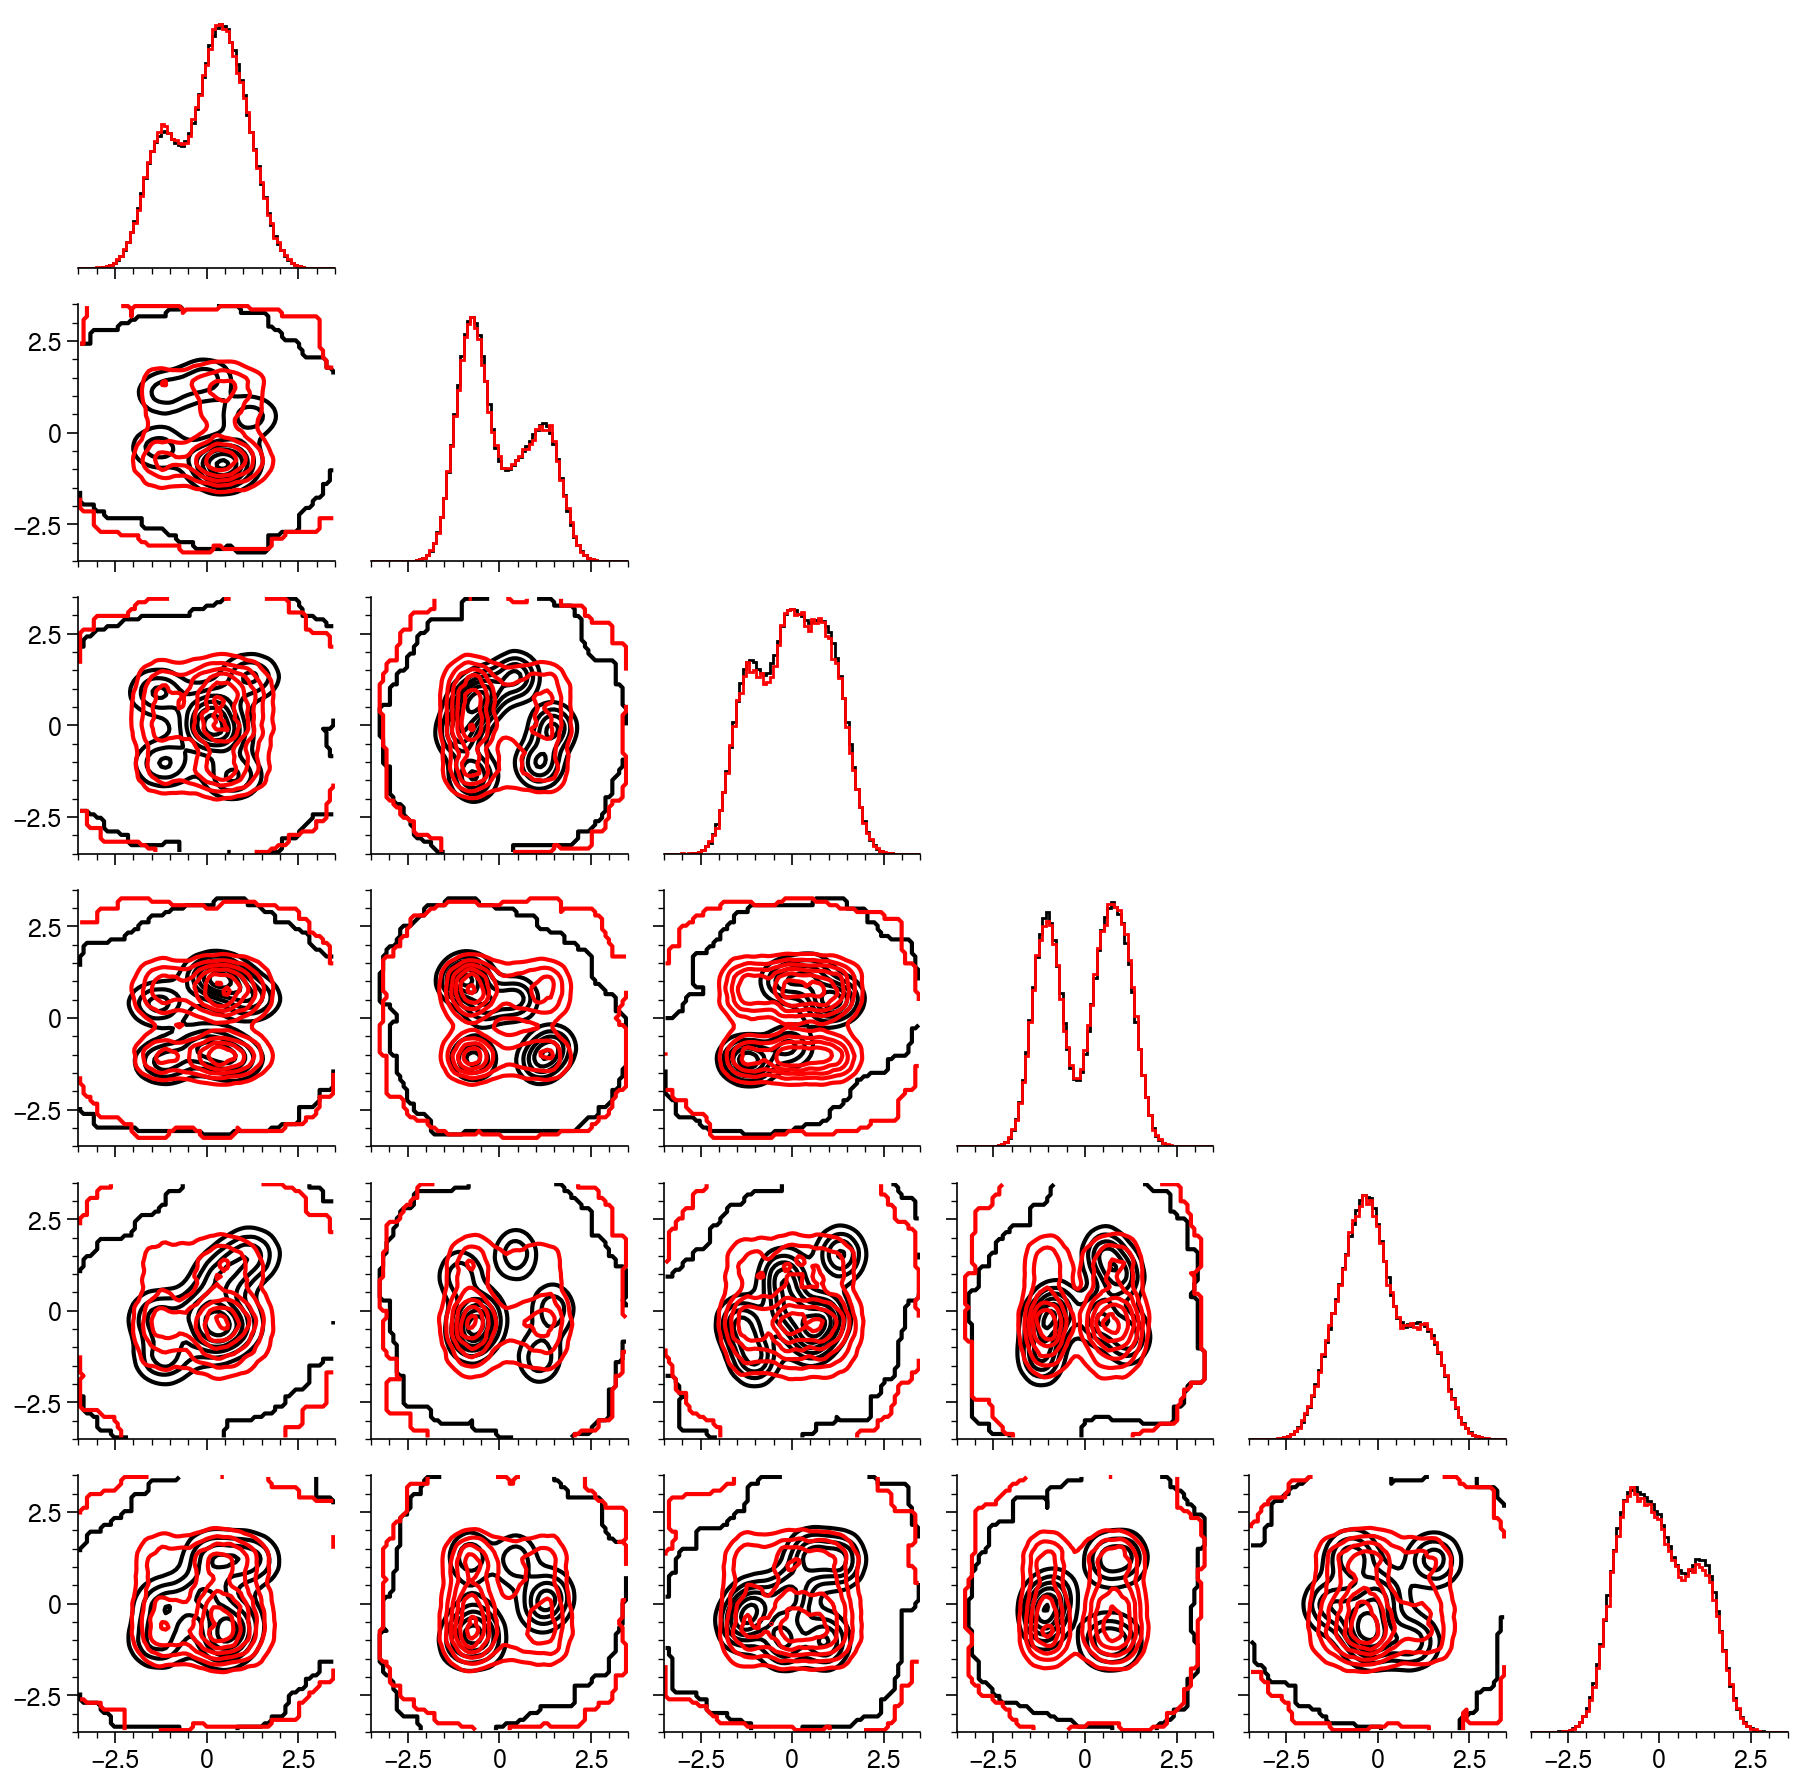

In [12]:
x_pred = model.unnormalize(model.sample(1_000_000))

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
for x, color in zip([x_true, x_pred], ["black", "red"]):
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color),
        mask=False,
        kind="contour",
        process_kws=dict(blur=1.0),
        color=color,
        N=7,
    )
plt.show()